# KPTK_build_models_[Base].ipynb

KPTK_build_models_Xception.ipynb

    [2021-11-12] [11-16 add more models]
    Reuse: Foot_Plantar_PP_mlG20210109_1800_twcc20210128_1000-TransferTune_Albu_20210203-RecheckTest\[PT\]OK2-testTrainFalse-noFuncode_HAL-label.ipynb
    
    Model_List[Xception]
    
    Model_List = [Xception, ResNet50, ResNet101, ResNet152, ResNet152V2, InceptionV3, MobileNet, MobileNetV2, 
    DenseNet121,DenseNet169,DenseNet201,
    NASNetMobile,NASNetLarge, 
    EfficientNetB0,
    EfficientNetB1,
    EfficientNetB3,
    EfficientNetB5,
    EfficientNetB7,
    ]
    
    1. Checking build and train every model of benchmark.
    2. Check build_model_XXXXX for better reuse! include difference rescal_layer input for specific model.
    3. Check TVT split
    4. Check mED is static 
    
    5. $time jupyter nbconvert --execute --to notebook KPTK_build_models_Base.ipynb just run nb in terminal.
    
    
***SPACE CELL***


In [1]:
# !sh ../install_env.sh

In [2]:
!export TF_ENABLE_AUTO_MIXED_PRECISION=0

In [3]:
%reset -f

In [4]:
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# plt.style.use("bmh")

import cv2
import tensorflow as tf

from datetime import datetime
import seaborn as sns

import errno

# albumentations
from functools import partial
# from albumentations import (
#     Compose, RandomBrightness, JpegCompression, HueSaturationValue, RandomContrast, HorizontalFlip,
#     Rotate
# )
import albumentations as A

# from adabelief_tf import AdaBeliefOptimizer


from pytictoc import TicToc

t = TicToc() #create instance of class

t.tic() #Start time

In [5]:
print(tf.__version__)
print(cv2.__version__)

2.5.0
4.5.3


### 2. Parameters

#### Image size, Batch size, toe/heel-offset.

In [6]:
BATCH_SIZE = 64 # 16 #32 #64 #128 #32 #64 #todo: reduce the BS maybe help to reduce the loss
img_height = 120 #512 #224 #100
img_width = 120 #512 #224 #100

y_offset_toe = 80
y_offset_heel = 280 #400-120=280

patience_toe_1 = 5
patience_toe_2 = 10
patience_heel_1 = 5
patience_heel_2 = 10

#### tf MirroredStrategy seting

In [7]:

# tf MirroredStrategy seting
strategy = tf.distribute.MirroredStrategy()
REPLICAS = strategy.num_replicas_in_sync
print('\nNumber of REPLICAS: {}\n'.format(REPLICAS))


MULTI_BATCH_SIZE = BATCH_SIZE * strategy.num_replicas_in_sync
print('BATCH_SIZE: {}, MULTI_BATCH_SIZE: {}'.format(BATCH_SIZE, MULTI_BATCH_SIZE))



INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)

Number of REPLICAS: 1

BATCH_SIZE: 64, MULTI_BATCH_SIZE: 64


In [8]:
# 自動調節tf.data管道
AUTOTUNE = tf.data.experimental.AUTOTUNE

### 3. Create the training dataset W/ croped


#### Load samples as data-farame

In [9]:

# data-org #
# ann = 'annotation_1424_merge.csv'
# im_p = 'train/images/'



# # data-org-augm#
# ann = 'annotation_2848_augm.csv'
# im_p = 'train_augm/images/'
# df[1335:]



# # data-train #
# ann = 'annotation_1345_good.csv'
# im_p = 'train/images/'



# data-augm #
# ann = 'annotation_2690_augm.csv'
# im_p = 'train_augm/images/'

# # data-train-HPL-1223
# ann = 'annotation_1123_HPL_Good.csv'
# im_p = 'train/images/'



# HAL_LABELING-train #
ann = '20211109-133352/HAL-Labeling_20211109-133352_rs42_noAug_df1345_.csv'
im_p = 'train/images/'


df = pd.read_csv(ann)
df[:10]

,images,x1,y1,x2,y2
0,image_0001.png,54.451683,135.123199,75.394951,384.379639
1,image_0002.png,61.442513,138.646210,40.848316,383.405762
2,image_0003.png,46.754402,117.371483,75.725739,367.023193
3,image_0004.png,65.820023,119.129929,33.653641,375.819153
4,image_0005.png,58.164394,147.843231,83.922630,380.064270
5,image_0006.png,55.113384,146.362488,29.693211,380.158783
6,image_0007.png,53.298878,121.596741,66.248657,366.226379
7,image_0008.png,61.680325,121.828499,35.355770,374.187622
8,image_0009.png,71.450912,159.187805,78.744621,383.658051
9,image_0010.png,59.819294,149.161926,32.126541,382.943573


In [10]:
len(df)

1345

#### Shuffle and reset index

In [11]:
# reset index
# df = df.sample(frac=1).reset_index(drop=True)

# fixed shuffle for compare, random_state=42
df = df.sample(frac=1, random_state=42).reset_index(drop=True)


In [12]:
df.head(10)

,images,x1,y1,x2,y2
0,image_0299.png,55.410290,108.355118,70.317078,382.264252
1,image_0274.png,50.153961,152.532455,28.971062,370.073303
2,image_6298.jpg,57.171066,148.318024,37.695858,383.680603
3,image_0218.jpg,54.144276,129.055725,77.358795,382.947205
4,image_0231.png,60.621296,106.951012,30.529104,383.577942
5,image_0841.png,49.417908,115.788345,29.445545,373.657471
6,image_0873.png,53.482864,153.361664,27.065651,381.730164
7,image_0168.jpg,58.723515,121.895470,32.735287,380.546570
8,image_6331.jpg,49.076584,130.301895,79.822174,383.398468
9,image_0078.png,60.806324,109.393562,21.642429,378.643341


See, the image_####.jpg now are random.

In [13]:
# fixed 1424 shuffle for compare, random_state=42
# 
# 0	image_6186.jpg	59	139	39	386
# 1	image_0678.png	60	138	78	384
# 2	image_6085.png	68	142	83	381
# 3	image_6006.png	63	120	32	386
# 4	image_0945.png	64	132	31	370
# 5	image_0539.png	63	160	39	366
# 6	image_0995.png	54	150	37	376
# 7	image_0725.png	49	136	32	383
# 8	image_0071.png	51	134	70	385
# 9	image_0124.png	65	136	33	384

In [14]:
# fixed 1345 shuffle for compare, random_state=42

# 0	image_0299.png	50	103	73	383
# 1	image_0274.png	50	154	27	369
# 2	image_6298.jpg	61	153	35	384
# 3	image_0218.jpg	52	138	79	381
# 4	image_0231.png	60	109	24	384
# 5	image_0841.png	67	113	30	374
# 6	image_0873.png	54	155	24	381
# 7	image_0168.jpg	60	119	31	380
# 8	image_6331.jpg	69	131	79	385
# 9	image_0078.png	63	104	19	378

#### Create tf.dataset (DS)

In [15]:
# from dataframe
list_ds = tf.data.Dataset.from_tensor_slices((df['images'], df['x1'], df['y1'], df['x2'], df['y2']))
# list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration=True) #todo: move to ds_pre. see https://www.tensorflow.org/api_docs/python/tf/data/Dataset#shuffle

In [16]:
# len(list_ds)#.shape() #take(1)

In [17]:
# # check The type specification of an element of this dataset.
# list_ds.element_spec


In [18]:
# for f,x1,y1,x2,y2 in list_ds.take(5):
#     print(f'take sample: {f} {x1} {y1} {x2} {y2}')

In [19]:
# # use np decode to UTF-8
# print(f.numpy().decode('UTF-8'))

In [20]:
# len(list_ds)

#### Check ds iterator for consuming

In [21]:
# # create a Python iterator

# it_list_ds = iter(list_ds) # Make sure iter ds only once.

In [22]:
# # using iter and consuming its elements using next: every print different image name.

# for i in range(4):
#     image, x1, y1, x2, y2 = next(it_list_ds)
#     print(image.numpy(), x1.numpy(), y1.numpy())

In [23]:
# # image_batch, label_batch = valid_ds_pre_s.as_numpy_iterator().next()
# # pred = model.predict_on_batch(image_batch)


# for i in range(4):
#     image, x1, y1, x2, y2 = list_ds.as_numpy_iterator().next()# every time create a new iter, so need put iter out of above cell.
#     print(image, x1, y1, x2, y2)
    
# iter_test_list = list_ds.as_numpy_iterator()
# print("===== Create iterator once and pull out to above cell. =====")
# for i in range(4):
#     image, x1, y1, x2, y2 = iter_test_list.next()
#     print(image, x1, y1, x2, y2)


#### Process path to image tensor in DS

In [24]:
#
# map list to ds, Toe part.
#

def decode_crop_png_toe(img):
    # convert the compressed string to a 3D uint8 tensor
    img = tf.io.decode_png(img, channels=3)
    # crop the toe from top-left corner [image, offset_height y1, offset_width x1, target_height, target_width]
    y1=y_offset_toe;    x1=0;    h=img_height;    w=img_width # not the pp location
    img = tf.image.crop_to_bounding_box(img, int(y1), int(x1), h, w)
    #img = tf.image.crop_to_bounding_box(img, int(y1), int(x1), int(y2)-int(y1), int(x2)-int(x1))
    # resize the image to the desired size
    return img

def process_path_toe(file_path,x1,y1,x2,y2):
    file_path = im_p + file_path
    #label = get_label(file_path)
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)#can read the byte string paths b'image_0001.png'
    img = decode_crop_png_toe(img)
    return img, [x1,y1-y_offset_toe]#Original [0,120]
    #return img, x1, y1-y_offset_toe #Original [0,120] #貌似ed不用改，蛋mse變超大
    #return img, [x1/120,(y1-y_offset_toe)/120]#normalized [0,1] xy <dtype: 'float64'>, no help.
    #return img, [(x1-60)/60,((y1-y_offset_toe)-60)/60]#normalized [-1,1] , no help.

#
# map list to ds, Heel part.
#

def decode_crop_png_heel(img):
    # convert the compressed string to a 3D uint8 tensor
    img = tf.io.decode_png(img, channels=3)
    # crop the toe from top-left corner [image, offset_height y1, offset_width x1, target_height, target_width]
    y2=y_offset_heel;    x2=0;    h=img_height;    w=img_width # not the pp location
    img = tf.image.crop_to_bounding_box(img, int(y2), int(x2), h, w)
    #img = tf.image.crop_to_bounding_box(img, int(y1), int(x1), int(y2)-int(y1), int(x2)-int(x1))
    # resize the image to the desired size
    return img

def process_path_heel(file_path,x1,y1,x2,y2):
    file_path = im_p + file_path
    #label = get_label(file_path)
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)#can read the byte string paths b'image_0001.png'
    img = decode_crop_png_heel(img)
    return img, [x2,y2-y_offset_heel]#Original [0,120]
    #return img, x2, y2-y_offset_heel #Original [0,120] #貌似ed不用改，蛋mse變超大
    #return img, [x2/120,(y2-y_offset_heel)/120]#normalized [0,1] xy <dtype: 'float64'>, no help.
    #return img, [(x2-60)/60,((y2-y_offset_heel)-60)/60]#normalized [-1,1] , no help.

#
# test how to put parameters to map
#

def t_ds_map(file_path,x1,y1,x2,y2):
#     img = get_img('train/images/' + str(file_path))
#     print(file_path)
    return file_path,x1,y1,x2,y2 #img, [x1,y1]
    

In [25]:
# Toe ds
train_ds_map_toe = list_ds.map(process_path_toe, num_parallel_calls=AUTOTUNE)

# Heel ds
train_ds_map_heel = list_ds.map(process_path_heel, num_parallel_calls=AUTOTUNE)

In [26]:
# for img, xy in train_ds_map_toe.take(1):
#     print(f'take sample: {xy}')
    
# print('f', f.dtype)
# print('xy', xy.dtype)

# for img, x, y in train_ds_map_toe.take(1):
#     print(f'take sample: {x} {y}')
    
# print('img', img.dtype)
# print('x', x.dtype)
# x

# for img, [x, y] in train_ds_map_toe.take(1):
#     print(f'take sample: {x} {y}')
    
# print('f', f.dtype)
# print('x', x.dtype)

In [27]:
# x

In [28]:
# for f,x1,y1,x2,y2 in train_ds_map.take(5):
#     print(f'take sample: {f} {x1} {y1} {x2} {y2}')

#### [new] Split train_ds_pre with ratio of validation %

[ToDo 20210201] keep orignal validation in 0.1, but augmenting train_ds in input layer or in the tf.ds.

In [29]:
# # split Toe
# val_size = int(tf.data.experimental.cardinality(train_ds_map_toe).numpy() * 0.2)
# # val_size = int(tf.data.experimental.cardinality(train_ds_map_toe).numpy() * 0.1)#no help

# train_ds_map_toe_s = train_ds_map_toe.skip(val_size)
# valid_ds_map_toe_s = train_ds_map_toe.take(val_size)

# print(len(train_ds_map_toe))
# print(val_size)
# print(tf.data.experimental.cardinality(train_ds_map_toe_s).numpy())
# print(tf.data.experimental.cardinality(valid_ds_map_toe_s).numpy())

In [30]:
# # split Heel
# val_size = int(tf.data.experimental.cardinality(train_ds_map_heel).numpy() * 0.2)
# # val_size = int(tf.data.experimental.cardinality(train_ds_map_heel).numpy() * 0.1)


# train_ds_map_heel_s = train_ds_map_heel.skip(val_size)
# valid_ds_map_heel_s = train_ds_map_heel.take(val_size)

# print(len(train_ds_map_heel))
# print(val_size)
# print(tf.data.experimental.cardinality(train_ds_map_heel_s).numpy())
# # print(tf.data.experimental.cardinality(valid_ds_map_heel_s).numpy())

# new split TVT train/val/test

In [31]:
# TVT ratio 0.7:0.15:0.15

In [32]:
# # Test how to split just 10 ds example

# test_list_ds = tf.data.Dataset.from_tensor_slices(range(20))

# # for ele in test_list_ds:
# #     print(ele)

    
# val_size = int(tf.data.experimental.cardinality(test_list_ds).numpy() * 0.15)
# print(" val_size:", val_size)    
    
# print("Train")
# for ele in test_list_ds.skip(val_size*2):
#     print('skip', ele)

# print("temp_take")    
# temp_take_list_ds = test_list_ds.take(val_size*2)

# print("val")
# for ele in temp_take_list_ds.take(val_size):
#     print('take', ele)

# print("Test")
# for ele in temp_take_list_ds.skip(val_size):
#     print('take', ele)


In [33]:
# # split Toe TVT train/val/test


# val_size = int(tf.data.experimental.cardinality(train_ds_map_toe).numpy() * 0.15)
# # val_size = int(tf.data.experimental.cardinality(train_ds_map_toe).numpy() * 0.1)#no help

# print(" val_size:", val_size)

# train_ds_map_toe_s = train_ds_map_toe.skip(val_size+val_size)
# temp_tdmt_s = train_ds_map_toe.take(val_size+val_size)

# valid_ds_map_toe_s = temp_tdmt_s.take(val_size)
# test_ds_map_toe_s = temp_tdmt_s.skip(val_size)

# print(len(train_ds_map_toe))
# print(val_size)
# print(tf.data.experimental.cardinality(train_ds_map_toe_s).numpy())
# print(tf.data.experimental.cardinality(valid_ds_map_toe_s).numpy())
# print(tf.data.experimental.cardinality(test_ds_map_toe_s).numpy())


# split Toe TTV train/test/val


val_size = int(tf.data.experimental.cardinality(train_ds_map_toe).numpy() * 0.15)
# val_size = int(tf.data.experimental.cardinality(train_ds_map_toe).numpy() * 0.1)#no help

print(" val_size:", val_size)

train_ds_map_toe_s = train_ds_map_toe.skip(val_size+val_size)
temp_tdmt_s = train_ds_map_toe.take(val_size+val_size)

test_ds_map_toe_s = temp_tdmt_s.take(val_size)
valid_ds_map_toe_s = temp_tdmt_s.skip(val_size)

print(len(train_ds_map_toe))
print(val_size)
print(tf.data.experimental.cardinality(train_ds_map_toe_s).numpy())
print(tf.data.experimental.cardinality(valid_ds_map_toe_s).numpy())
print(tf.data.experimental.cardinality(test_ds_map_toe_s).numpy())


 val_size: 201
1345
201
943
201
201


In [34]:
# # split Heel TVT train/val/test


# val_size = int(tf.data.experimental.cardinality(train_ds_map_heel).numpy() * 0.15)
# # val_size = int(tf.data.experimental.cardinality(train_ds_map_heel).numpy() * 0.1)
# print("val_size:", val_size)

# train_ds_map_heel_s = train_ds_map_heel.skip(val_size+val_size)
# temp_tdmh_s = train_ds_map_heel.take(val_size+val_size)

# valid_ds_map_heel_s = temp_tdmh_s.take(val_size)
# test_ds_map_heel_s = temp_tdmh_s.skip(val_size)

# print("train_ds_map_heel: ", len(train_ds_map_heel))
# print("train:", tf.data.experimental.cardinality(train_ds_map_heel_s).numpy())
# print("valid:", tf.data.experimental.cardinality(valid_ds_map_heel_s).numpy())
# print("test :", tf.data.experimental.cardinality(test_ds_map_heel_s).numpy())

# split Heel TTV train/test/val


val_size = int(tf.data.experimental.cardinality(train_ds_map_heel).numpy() * 0.15)
# val_size = int(tf.data.experimental.cardinality(train_ds_map_heel).numpy() * 0.1)
print("val_size:", val_size)

train_ds_map_heel_s = train_ds_map_heel.skip(val_size+val_size)
temp_tdmh_s = train_ds_map_heel.take(val_size+val_size)

test_ds_map_heel_s = temp_tdmh_s.take(val_size)
valid_ds_map_heel_s = temp_tdmh_s.skip(val_size)

print("train_ds_map_heel: ", len(train_ds_map_heel))
print("train:", tf.data.experimental.cardinality(train_ds_map_heel_s).numpy())
print("valid:", tf.data.experimental.cardinality(valid_ds_map_heel_s).numpy())
print("test :", tf.data.experimental.cardinality(test_ds_map_heel_s).numpy())

val_size: 201
train_ds_map_heel:  1345
train: 943
valid: 201
test : 201


# Albumentation pipeline

In [35]:

# # for NO keypoint augment
# transforms = A.Compose([
#             A.RandomBrightness(limit=0.1, p=0.5),
#             A.JpegCompression(quality_lower=85, quality_upper=100, p=0.5),
#             A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.5),
#             A.RandomContrast(limit=0.2, p=0.5),
#             A.FancyPCA(alpha=0.1, always_apply=False, p=0.5),
#             A.Downscale(scale_min=0.7, scale_max=0.9, interpolation=0, always_apply=False, p=0.5), #0.8~0.99 may better
#             A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2, always_apply=False, p=0.5),
#             A.CLAHE(clip_limit=4.0, tile_grid_size=(8, 8), always_apply=False, p=0.5),
# #             A.GlassBlur(sigma=0.9, max_delta=2, iterations=2, always_apply=False, mode='fast', p=0.5),
# #             A.GaussNoise(var_limit=(10.0, 50.0), mean=0, always_apply=False, p=0.5),
# #             A.GaussianBlur(blur_limit=(3, 7), sigma_limit=0, always_apply=False, p=0.5),
# #             A.HorizontalFlip(),
# ])


# def aug_fn(image, img_size):
#     data = {"image":image}
#     aug_data = transforms(**data)
#     aug_img = aug_data["image"]
# #     aug_img = tf.cast(aug_img/255.0, tf.float32)
#     aug_img = tf.cast(aug_img, tf.float32)
#     aug_img = tf.image.resize(aug_img, size=[img_size, img_size])
#     return aug_img

# def process_data(image, label, img_size):
#     aug_img = tf.numpy_function(func=aug_fn, inp=[image, img_size], Tout=tf.float32)
#     return aug_img, label

# def set_shapes(img, label, img_shape=(120,120,3)):
#     img.set_shape(img_shape)
# #     label.set_shape([]) # commited for go around error
#     return img, label





# # for NO keypoint augment AND for OneOf[] for better heel loss.
# transforms_oneof = A.Compose(A.OneOf([
#             A.RandomBrightness(limit=0.1, p=0.5),
#             A.JpegCompression(quality_lower=85, quality_upper=100, p=0.5),
#             A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.5),
#             A.RandomContrast(limit=0.2, p=0.5),
#             A.FancyPCA(alpha=0.1, always_apply=False, p=0.5),
#             A.Downscale(scale_min=0.7, scale_max=0.9, interpolation=0, always_apply=False, p=0.5),
#             A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2, always_apply=False, p=0.5),
#             A.CLAHE(clip_limit=4.0, tile_grid_size=(8, 8), always_apply=False, p=0.5),
#             A.GlassBlur(sigma=0.9, max_delta=2, iterations=2, always_apply=False, mode='fast', p=0.5),
#             A.GaussNoise(var_limit=(10.0, 50.0), mean=0, always_apply=False, p=0.5),
#             A.GaussianBlur(blur_limit=(3, 7), sigma_limit=0, always_apply=False, p=.5)
# #             A.HorizontalFlip(),
#             ]),p=0.5)


# def aug_fn_oneof(image, img_size):
#     data = {"image":image}
#     aug_data = transforms_oneof(**data)
#     aug_img = aug_data["image"]
# #     aug_img = tf.cast(aug_img/255.0, tf.float32)
#     aug_img = tf.cast(aug_img, tf.float32)
#     aug_img = tf.image.resize(aug_img, size=[img_size, img_size])
#     return aug_img

# def process_data_oneof(image, label, img_size):
#     aug_img = tf.numpy_function(func=aug_fn_oneof, inp=[image, img_size], Tout=tf.float32)
#     return aug_img, label








# Testing keypoints augment
transforms = A.Compose([
            A.RandomBrightness(limit=0.1, p=0.5),
            A.JpegCompression(quality_lower=85, quality_upper=100, p=0.5),
            A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.5),
            A.RandomContrast(limit=0.2, p=0.5),
            A.FancyPCA (alpha=0.1, always_apply=False, p=1),
            A.Downscale (scale_min=0.7, scale_max=0.9, interpolation=0, always_apply=False, p=0.5),
            A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2, always_apply=False, p=0.5),
            A.CLAHE (clip_limit=4.0, tile_grid_size=(8, 8), always_apply=False, p=0.5),
            A.HorizontalFlip(p=0.5),
            ]
            , 
            keypoint_params=A.KeypointParams(format='xy'),  #currently not works for tf.ds yet.
            )



# Testing keypoints augment
# @tf.function
def aug_fn(image, keypoints, img_size):
#     print('Check keypoints aug_fun 00:', keypoints) # Check keypoints aug_fun 00: [[53 58]]
#     data = {"image":image}
    aug_data = transforms(image=image, keypoints=keypoints)
    aug_img = aug_data["image"]
    aug_xy  = aug_data["keypoints"]
#     aug_img = tf.cast(aug_img/255.0, tf.float32)
    aug_img = tf.cast(aug_img, tf.float32)
    aug_img = tf.image.resize(aug_img, size=[img_size, img_size])
#     print('Check aug_xy:', aug_xy) # Check aug_xy: [(95, 45)]
    return aug_img, aug_xy 

# @tf.function
def process_data(image, keypoints, img_size):
    
#     print('Check keypoints process01:', keypoints, np.shape(keypoints), type(keypoints))
        
#     keypoints = tf.make_ndarray(keypoints)
#     keypoints = np.array(keypoints)
#     keypoints = list(keypoints)
#     keypoints = np.asarray(keypoints, dtype=np.float32)
#     keypoints = tf.make_ndarray(keypoints.op.get_attr('value'))

#     keypoints = tf.reshape(keypoints, [1, 2])
    keypoints = tf.reshape(keypoints, [1, 2]) # for 'convert_keypoint_to_albumentations'
#     keypoints = np.reshape(keypoints, (1, 2))#not support tensor with np.call.

#     print('Check keypoints process02:', keypoints, np.shape(keypoints), type(keypoints))

#     aug_img, aug_xy = tf.numpy_function(func=aug_fn, inp=[image, img_size], Tout=tf.float32)
#     aug_img, aug_xy = tf.py_function(func=aug_fn, inp=[image, keypoints, img_size], Tout=[tf.float32, tf.int64])#for tensors.
    aug_img, aug_xy = tf.numpy_function(func=aug_fn, inp=[image, keypoints, img_size], Tout=[tf.float32, tf.int64])
#     print('Check keypoints process03:', aug_xy)
    
    aug_xy = tf.reshape(keypoints, [2,]) # for 'tf ds tarining'
#     print('Check keypoints process04:', aug_xy)
        
    return aug_img, aug_xy 


def set_shapes(img, label, img_shape=(120,120,3)):
    img.set_shape(img_shape)
#     label.set_shape([]) # commited for go around error
    return img, label

/usr/local/lib/python3.8/dist-packages/albumentations/augmentations/transforms.py:1800: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/albumentations/augmentations/transforms.py:965: FutureWarning: This class has been deprecated. Please use ImageCompression
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/albumentations/augmentations/transforms.py:1826: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(


#### prepare train_ds_prefetch

In [36]:
def configure_for_performance_cache_train(ds, cache=True, augment=False):

    
    """#TODO: need to check the parse logic of ds.cache.
    if cache:
        print("Check cache-f1 to file:", cache)
        if isinstance(cache, str):
            ds = ds.cache(cache)
            print("Check cache-f2 to file:", cache)
    else:
        ds = ds.cache()
        print("Check cache in memory:", cache)
    """    
    if cache:
        ds = ds.cache()
        print("Check cache in memory:Y", cache)
    else:
        print("Check cache in memory:N", cache)
        
    if augment:
        ds = ds.map(partial(process_data, img_size=120),num_parallel_calls=AUTOTUNE)
        ds = ds.map(set_shapes, num_parallel_calls=AUTOTUNE)
        print("Check augment :Y", augment)
    else:
        print("Check augment :N", augment)
    
    #ds = ds.repeat()#TODO:2020-12-14: test
    #ds = ds.shuffle(buffer_size=MULTI_BATCH_SIZE*2) # (buffer_size=MULTI_BATCH_SIZE*5) 6sec,buffer_size=1000 take few sec. or buffer_size=image_count <- take too long # each take ds take 30~45 sec, TODO!!
    ds = ds.shuffle(len(list_ds), reshuffle_each_iteration=True) #todo: move to ds_pre. see https://www.tensorflow.org/api_docs/python/tf/data/Dataset#shuffle
    ds = ds.batch(MULTI_BATCH_SIZE)#MULTI_BATCH_SIZE for multi-GPUs
    ds = ds.prefetch(buffer_size=AUTOTUNE) #buffer_size=AUTOTUNE seem no speed improve
    
    print("Check ds cache[{}] and augment[{}]".format(cache, augment))
    
    return ds


# def configure_for_performance_cache_train_oneof(ds, cache=True, augment=False):

    
#     """#TODO: need to check the parse logic of ds.cache.
#     if cache:
#         print("Check cache-f1 to file:", cache)
#         if isinstance(cache, str):
#             ds = ds.cache(cache)
#             print("Check cache-f2 to file:", cache)
#     else:
#         ds = ds.cache()
#         print("Check cache in memory:", cache)
#     """    
#     if cache:
#         ds = ds.cache()
#         print("Check cache in memory:Y", cache)
#     else:
#         print("Check cache in memory:N", cache)
        
#     if augment:
#         ds = ds.map(partial(process_data_oneof, img_size=120),num_parallel_calls=AUTOTUNE)
#         ds = ds.map(set_shapes, num_parallel_calls=AUTOTUNE)
#         print("Check augment :Y", augment)
#     else:
#         print("Check augment :N", augment)
    
#     #ds = ds.repeat()#TODO:2020-12-14: test
#     #ds = ds.shuffle(buffer_size=MULTI_BATCH_SIZE*2) # (buffer_size=MULTI_BATCH_SIZE*5) 6sec,buffer_size=1000 take few sec. or buffer_size=image_count <- take too long # each take ds take 30~45 sec, TODO!!
#     ds = ds.shuffle(len(list_ds), reshuffle_each_iteration=True) #todo: move to ds_pre. see https://www.tensorflow.org/api_docs/python/tf/data/Dataset#shuffle
#     ds = ds.batch(MULTI_BATCH_SIZE)#MULTI_BATCH_SIZE for multi-GPUs
#     ds = ds.prefetch(buffer_size=AUTOTUNE) #buffer_size=AUTOTUNE seem no speed improve
    
#     print("Check ds cache[{}] and augment[{}]".format(cache, augment))
    
#     return ds




def configure_for_performance_cache_val(ds, cache=True, augment=False):

    
    """#TODO: need to check the parse logic of ds.cache
    TODO:test remove ds.shuffle from val_ds.
    .
    if cache:
        print("Check cache-f1 to file:", cache)
        if isinstance(cache, str):
            ds = ds.cache(cache)
            print("Check cache-f2 to file:", cache)
    else:
        ds = ds.cache()
        print("Check cache in memory:", cache)
    """    
    if cache:
        ds = ds.cache()
        print("Check cache in memory:Y", cache)
    else:
        print("Check cache in memory:N", cache)
        
    if augment:
#         ds = ds.map(data_augment, num_parallel_calls=AUTOTUNE)
        ds = ds.map(AA, num_parallel_calls=AUTOTUNE)
#         ds = ds.map(RA, num_parallel_calls=AUTOTUNE)
        print("Check augment :Y", augment)
    else:
        print("Check augment :N", augment)
    
    #ds = ds.repeat()#TODO:2020-12-14: test
    #ds = ds.shuffle(buffer_size=MULTI_BATCH_SIZE*2) # (buffer_size=MULTI_BATCH_SIZE*5) 6sec,buffer_size=1000 take few sec. or buffer_size=image_count <- take too long # each take ds take 30~45 sec, TODO!!
#     ds = ds.shuffle(len(list_ds), reshuffle_each_iteration=False) #todo: move to ds_pre. see https://www.tensorflow.org/api_docs/python/tf/data/Dataset#shuffle
    ds = ds.batch(MULTI_BATCH_SIZE)#MULTI_BATCH_SIZE for multi-GPUs
    ds = ds.prefetch(buffer_size=AUTOTUNE) #buffer_size=AUTOTUNE seem no speed improve
    
    print("Check ds cache[{}] and augment[{}]".format(cache, augment))
    
    return ds


In [37]:
# """
# Prepare the ds properties (cache, augment, bs, shuffle, prefetch, etc.) for better performance.
# """
# # Toe ds_pre
# train_ds_pre_toe = configure_for_performance_cache_train(train_ds_map_toe)

# # Heel ds_pre
# train_ds_pre_heel = configure_for_performance_cache_val(train_ds_map_heel)

#### All split ds_prefetch
* train_ds_map_toe_s = train_ds_map_toe.skip(val_size)
* valid_ds_map_toe_s = train_ds_map_toe.take(val_size)

* train_ds_map_heel_s = train_ds_map_heel.skip(val_size)
* valid_ds_map_heel_s = train_ds_map_heel.take(val_size)


In [38]:
"""
Prepare the ds properties (cache, augment, bs, shuffle, prefetch, etc.) for better performance.
"""
# Toe ds_pre
train_ds_pre_toe_s = configure_for_performance_cache_train(train_ds_map_toe_s, augment=False) #True False
valid_ds_pre_toe_s = configure_for_performance_cache_val(valid_ds_map_toe_s)

test_ds_pre_toe_s = configure_for_performance_cache_val(test_ds_map_toe_s)



# Heel ds_pre
train_ds_pre_heel_s = configure_for_performance_cache_train(train_ds_map_heel_s, augment=False) #True
valid_ds_pre_heel_s = configure_for_performance_cache_val(valid_ds_map_heel_s)

test_ds_pre_heel_s = configure_for_performance_cache_val(test_ds_map_heel_s)

Check cache in memory:Y True
Check augment :N False
Check ds cache[True] and augment[False]
Check cache in memory:Y True
Check augment :N False
Check ds cache[True] and augment[False]
Check cache in memory:Y True
Check augment :N False
Check ds cache[True] and augment[False]
Check cache in memory:Y True
Check augment :N False
Check ds cache[True] and augment[False]
Check cache in memory:Y True
Check augment :N False
Check ds cache[True] and augment[False]
Check cache in memory:Y True
Check augment :N False
Check ds cache[True] and augment[False]


#### Check ds_prefetch samples

In [39]:
# create it_ds once
it_train_ds_pre_toe_s = iter(train_ds_pre_toe_s)

batch * multi: 64 , MULTI_BATCH_SIZE= 64
 [min,max]: 0 255
Check lables: [50.86468124 27.60974121]
 [min,max]: 0 255
Check lables: [50.56474686 45.77033997]
 [min,max]: 0 255
Check lables: [58.37937164 38.46179199]
 [min,max]: 3 255
Check lables: [55.4120903  54.73576355]
 [min,max]: 0 255
Check lables: [66.70417786 42.37931824]
 [min,max]: 0 255
Check lables: [63.82985306 55.39358521]
 [min,max]: 0 255
Check lables: [66.62605286 94.36608887]
 [min,max]: 3 255
Check lables: [56.48731232 47.17667389]
 [min,max]: 3 255
Check lables: [54.51105118 60.64546204]
 [min,max]: 0 255
Check lables: [58.4798851  56.74635315]
 [min,max]: 3 255
Check lables: [56.86246872 57.8638916 ]
 [min,max]: 0 255


/home/u3148947/.local/lib/python3.8/site-packages/matplotlib/text.py:1215: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


Check lables: [52.30554581 53.63803101]
 [min,max]: 0 255
Check lables: [63.67213821 42.70158386]
 [min,max]: 3 255
Check lables: [55.05119324 57.96560669]
 [min,max]: 3 255
Check lables: [56.92141342 62.68624878]
 [min,max]: 0 255
Check lables: [49.26692963 74.62277222]
CPU times: user 1.93 s, sys: 224 ms, total: 2.16 s
Wall time: 5.52 s


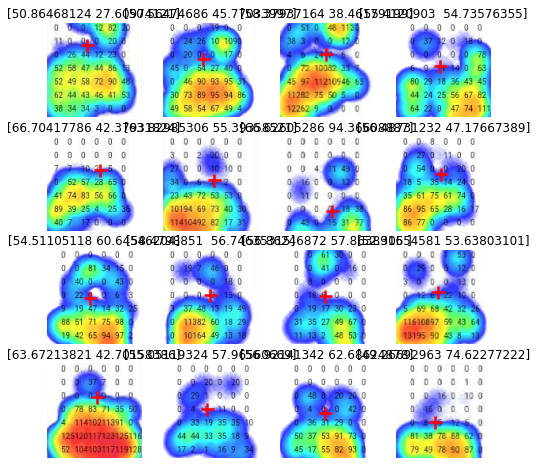

In [40]:
%%time

# for albu keypoint

# for original return aug_img, , aug_xy 


image_batch, label_batch = next(it_train_ds_pre_toe_s)

fig = plt.figure(figsize=(8, 8))
print('batch * multi:', len(label_batch), ', MULTI_BATCH_SIZE=', MULTI_BATCH_SIZE)
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    plt.title(label_batch[i].numpy())
    plt.axis("off")

    plt.plot(label_batch[i].numpy()[0], label_batch[i].numpy()[1], 'r+', markersize=13, mew=2.5)

    
    # 2021-11-05
    # Check jpg, png agter ds is [0-255]
    print(' [min,max]:', image_batch[i].numpy().min() , image_batch[i].numpy().max())
    
    
    
    print(f'Check lables: {label_batch[i]}')


In [41]:
# create it_ds once
it_train_ds_pre_heel_s = iter(train_ds_pre_heel_s)

batch * multi: 64 , MULTI_BATCH_SIZE= 64
Check lables: [74.16827393 85.76309204]
Check lables: [93.2453537  81.78585815]
Check lables: [ 77.25805664 100.83886719]
Check lables: [ 80.50902557 103.03088379]
Check lables: [ 83.17529297 104.68838501]
Check lables: [ 75.27547455 101.70043945]
Check lables: [ 28.09698868 101.16116333]
Check lables: [ 82.753685   103.85720825]
Check lables: [ 76.612854   102.74234009]
Check lables: [79.46663666 99.63952637]
Check lables: [ 78.64955902 103.34197998]
Check lables: [71.61573792 93.06069946]
Check lables: [ 36.79048538 100.34063721]
Check lables: [ 77.52120972 103.78637695]
Check lables: [77.92642975 92.83407593]
Check lables: [31.8314991  91.51165771]
CPU times: user 1.6 s, sys: 94.1 ms, total: 1.69 s
Wall time: 806 ms


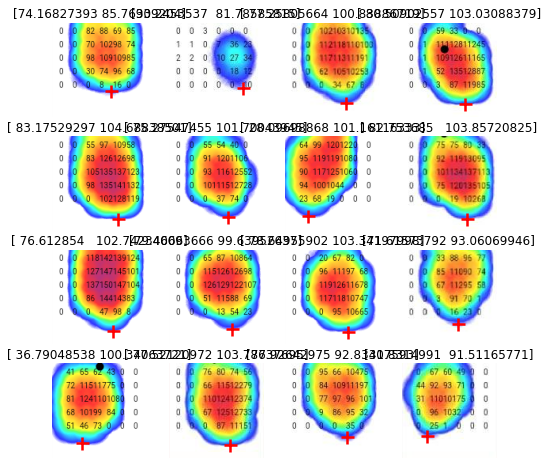

In [42]:
%%time

# for albu keypoint

# for original return aug_img, , aug_xy 


image_batch, label_batch = next(it_train_ds_pre_heel_s)

fig = plt.figure(figsize=(8, 8))
print('batch * multi:', len(label_batch), ', MULTI_BATCH_SIZE=', MULTI_BATCH_SIZE)
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    plt.title(label_batch[i].numpy())
    plt.axis("off")

    plt.plot(label_batch[i].numpy()[0], label_batch[i].numpy()[1], 'r+', markersize=13, mew=2.5)

    print(f'Check lables: {label_batch[i]}')

In [43]:
# create it_ds once
it_valid_ds_pre_toe_s = iter(valid_ds_pre_toe_s)

batch * multi: 64 , MULTI_BATCH_SIZE= 64
[min,max]: 0 255
Check lables: [57.99534607 41.85908508]
[min,max]: 3 255
Check lables: [60.38032913 42.59918213]
[min,max]: 3 255
Check lables: [56.91408157 42.62082672]
[min,max]: 5 255
Check lables: [52.27865601 71.05780029]
[min,max]: 0 255
Check lables: [64.33740997 29.23454285]
[min,max]: 0 255
Check lables: [58.23761749 49.95489502]
[min,max]: 5 255
Check lables: [49.31562805 80.17041016]
[min,max]: 3 255
Check lables: [54.829216   41.87064362]
[min,max]: 0 255
Check lables: [57.46092987 53.94021606]
[min,max]: 3 255
Check lables: [59.95227432 28.38187408]
[min,max]: 0 255
Check lables: [60.57949448 63.90339661]
[min,max]: 0 255
Check lables: [62.60020065 39.97647095]
[min,max]: 3 255
Check lables: [56.92157745 56.49900818]
[min,max]: 0 255
Check lables: [61.54311752 27.35160828]
[min,max]: 0 255
Check lables: [57.22765732 55.79364014]
[min,max]: 0 255
Check lables: [49.42630386 40.19502258]
CPU times: user 558 ms, sys: 47.8 ms, total: 60

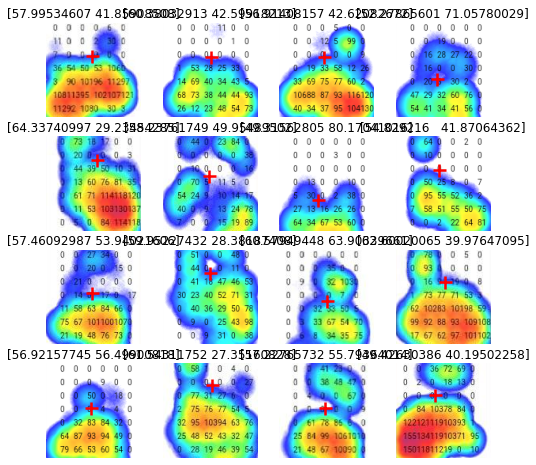

In [44]:
%%time

# for albu keypoint

# for return aug_img, aug_xy 


# image_batch, label_batch = next(it_valid_ds_pre_toe_s)
image_batch, label_batch = next(it_valid_ds_pre_toe_s)

plt.figure(figsize=(8, 8))
# for images, labels in valid_ds_pre_toe_s.take(1):
print('batch * multi:', len(label_batch), ', MULTI_BATCH_SIZE=', MULTI_BATCH_SIZE)
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    plt.title(label_batch[i].numpy())
    plt.axis("off")

    plt.plot(label_batch[i].numpy()[0], label_batch[i].numpy()[1], 'r+', markersize=13, mew=2.5)
    
    # 2021-11-05
    # Check jpg, png agter ds is [0-255]
    print('[min,max]:', image_batch[i].numpy().min() , image_batch[i].numpy().max())

    print(f'Check lables: {label_batch[i]}')
        

In [45]:
# %%time

# #2021-01-30
# # for change default [x, y] tuple to x, y

# # plot_number_of_sample = MULTI_BATCH_SIZE
# # col_size = row_size = int(np.sqrt(MULTI_BATCH_SIZE))
# # # row_size = np.sqrt(MULTI_BATCH_SIZE)
# # print(col_size)

# plt.figure(figsize=(8, 8))
# for images, x, y in train_ds_pre_toe_s.take(1):
#     print('batch * multi:', len(labels), ', MULTI_BATCH_SIZE=', MULTI_BATCH_SIZE)
#     for i in range(16):
#         ax = plt.subplot(4, 4, i + 1)
#         plt.imshow(images[i].numpy().astype("uint8"))
#         plt.title([labels[i].numpy()])
#         plt.axis("off")
        
#         plt.plot(x[i].numpy(), y[i].numpy(), 'r+', markersize=13, mew=2.5)

In [46]:
# %%time

# # plot_number_of_sample = MULTI_BATCH_SIZE
# # col_size = row_size = int(np.sqrt(MULTI_BATCH_SIZE))
# # # row_size = np.sqrt(MULTI_BATCH_SIZE)
# # print(col_size)

# plt.figure(figsize=(8, 8))
# for images, labels in train_ds_pre_toe_s.take(1):
#     print('batch * multi:', len(labels), ', MULTI_BATCH_SIZE=', MULTI_BATCH_SIZE)
#     for i in range(16):
#         ax = plt.subplot(4, 4, i + 1)
#         plt.imshow(images[i].numpy().astype("uint8"))
#         plt.title([labels[i].numpy()])
#         plt.axis("off")
        
#         plt.plot(labels[i].numpy()[0], labels[i].numpy()[1], 'r+', markersize=13, mew=2.5)

In [47]:
# %%time

# # NOrmalized xy to [0, 1] #

# # plot_number_of_sample = MULTI_BATCH_SIZE
# # col_size = row_size = int(np.sqrt(MULTI_BATCH_SIZE))
# # # row_size = np.sqrt(MULTI_BATCH_SIZE)
# # print(col_size)

# plt.figure(figsize=(8, 8))
# for images, labels in train_ds_pre_toe_s.take(1):
#     print('batch * multi:', len(labels), ', MULTI_BATCH_SIZE=', MULTI_BATCH_SIZE)
#     for i in range(16):
#         ax = plt.subplot(4, 4, i + 1)
#         plt.imshow(images[i].numpy().astype("uint8"))
#         plt.title([labels[i].numpy()])
#         plt.axis("off")
        
#         plt.plot(labels[i].numpy()[0]*120, labels[i].numpy()[1]*120, 'r+', markersize=13, mew=2.5)

In [48]:
# %%time

# # NOrmalized xy to [0, 1] #

# # plot_number_of_sample = MULTI_BATCH_SIZE
# # col_size = row_size = int(np.sqrt(MULTI_BATCH_SIZE))
# # # row_size = np.sqrt(MULTI_BATCH_SIZE)
# # print(col_size)

# plt.figure(figsize=(8, 8))
# for images, labels in train_ds_pre_heel_s.take(1):
#     print('batch * multi:', len(labels), ', MULTI_BATCH_SIZE=', MULTI_BATCH_SIZE)
#     for i in range(16):
#         ax = plt.subplot(4, 4, i + 1)
#         plt.imshow(images[i].numpy().astype("uint8"))
#         plt.title([labels[i].numpy()])
#         plt.axis("off")
        
#         plt.plot(labels[i].numpy()[0]*120, labels[i].numpy()[1]*120, 'r+', markersize=13, mew=2.5)

In [49]:
# %%time

# plt.figure(figsize=(8, 8))
# for images, labels in train_ds_pre_heel_s.take(1):
#     print('batch * multi:', len(labels))
#     for i in range(16):
#         ax = plt.subplot(4, 4, i + 1)
#         plt.imshow(images[i].numpy().astype("uint8"))
#         plt.title(str(labels[i].numpy()))
#         plt.axis("off")
        
#         plt.plot(labels[i].numpy()[0], labels[i].numpy()[1], 'b+', markersize=13, mew=2.5)
# #         print((labels[i].numpy()[0], labels[i].numpy()[1]))

In [50]:
# create it_ds once
# it_train_ds_pre_toe = iter(train_ds_pre_toe_s)

In [51]:
# image_batch, label_batch = next(it_train_ds_pre_toe)

# plt.figure(figsize=(18, 18))
# for i in range(64):
#     ax = plt.subplot(8, 8, i + 1)
#     plt.imshow(image_batch[i].numpy().astype("uint8"))
#     plt.title('x1,y1:' + str(label_batch[i].numpy()))
#     plt.axis("off")
    
#     #print(label_batch[i])
#     plt.plot(label_batch[i].numpy()[0], label_batch[i].numpy()[1], 'r+', markersize=13, mew=2.5)

### [OLD] Split train_ds_pre

##### train_ds_pre_s
##### valid_ds_pre_s 

### re-set to toe/heel split
##### train_ds_pre_toe_s
##### valid_ds_pre_toe_s

##### train_ds_pre_heel_s
##### valid_ds_pre_heel_s

#### split Toe

In [52]:
# # split Toe
# val_size = int(tf.data.experimental.cardinality(train_ds_pre_toe).numpy() * 0.2)

# train_ds_pre_toe_s = train_ds_pre_toe.skip(val_size)
# valid_ds_pre_toe_s = train_ds_pre_toe.take(val_size)

# print(len(train_ds_pre_toe))
# print(val_size)
# print(tf.data.experimental.cardinality(train_ds_pre_toe_s).numpy())
# print(tf.data.experimental.cardinality(valid_ds_pre_toe_s).numpy())

#### split Heel

In [53]:
# # split Heel
# val_size = int(tf.data.experimental.cardinality(train_ds_pre_heel).numpy() * 0.2)

# train_ds_pre_heel_s = train_ds_pre_heel.skip(val_size)
# valid_ds_pre_heel_s = train_ds_pre_heel.take(val_size)

# print(len(train_ds_pre_heel))
# print(val_size)
# print(tf.data.experimental.cardinality(train_ds_pre_heel_s).numpy())
# print(tf.data.experimental.cardinality(valid_ds_pre_heel_s).numpy())

### 3.Loss function

* mae
* euclidean distance
* others


        # 'x' is [[1, 1, 1]
        #         [1, 1, 1]]
        tf.reduce_sum(x) ==> 6
        tf.reduce_sum(x, 0) ==> [2, 2, 2]
        tf.reduce_sum(x, 1) ==> [3, 3]
        the function is default for 2-D array, therefor, in our 1-D [x1,y1] to [x2,y2] the axis should be '0' or just leave it.
        
        tf.sqrt need 	A tf.Tensor of type bfloat16, half, float32, float64, complex64, complex128
        so, convert it first.

should be -> tf.Tensor([56 39], shape=(2,), dtype=int64)

In [54]:
y_true = [10, 10]
y_pred = [10, 20]

# y_true = [1.00000000000000000000123, 10]
# y_pred = [1.0, 10.000000000000000000000000001]

# y_true = [1.0000123, 10]
# y_pred = [1.0, 10.0000321]


In [55]:
# mae

loss_mae = tf.keras.losses.MAE(
    y_true, y_pred
)

loss_mae

<tf.Tensor: shape=(), dtype=int32, numpy=5>

In [56]:
# ed

# loss_ed = tf.sqrt(tf.reduce_sum(tf.square(tf.constant(y_true) - tf.constant(y_pred)), 0))

# loss_ed = tf.sqrt(tf.reduce_sum(tf.square(tf.Variable(y_true) - tf.Variable(y_pred)), 0))

loss_ed = tf.sqrt(tf.reduce_sum(tf.square(tf.cast(y_true, tf.float32) - tf.cast(y_pred, tf.float32)), 0))

loss_ed

<tf.Tensor: shape=(), dtype=float32, numpy=10.0>

In [57]:
def ed_loss(y_true, y_pred):
    return tf.sqrt(tf.reduce_sum(tf.square(tf.cast(y_true, tf.float32) - tf.cast(y_pred, tf.float32)), 0))

# fix NaN in euclidean distance
# tf.maximum(d, 1e-9), to keep atlease is 1e-9.
# def ed_loss(y_true, y_pred):
#     return tf.sqrt(tf.maximum(tf.reduce_sum(tf.square(tf.cast(y_true, tf.float32) - tf.cast(y_pred, tf.float32)), 0), 1e-9))


In [58]:
# check the euclidean distance loss
ed_loss(y_true, y_pred).numpy()

10.0

In [59]:
ed_loss(y_true, y_pred)

<tf.Tensor: shape=(), dtype=float32, numpy=10.0>

#### mean Euclidean distance 

* here the y_true and y_pred is 2-D array. the axis use 1.


* NOTE: LB評分的mean euclidean distance功能，應該跟model.evaluate()一樣so不需重新寫。evaluate()會自動用loss (model.metrics_names)計算後在自動平均，而模型loss我們是用ed-loss取代。

In [60]:
# y_true = [[60, 76],
#        [58, 49 ],
#        [63, 67 ],
#        [58 , 57]]
# y_pred = [[59.927303, 76.471214],
#        [58.056904, 49.98754 ],
#        [63.067844, 67.03861 ],
#        [58.70202 , 57.372707]]

y_true = [[60, 70],
       [70, 80]]
y_pred = [[61, 71],
       [72, 82]]

# y_true = [(60, 70),
#        (70, 80)]
# y_pred = [(61, 71),
#        (72, 82)]

In [61]:
tf.square(tf.cast(y_true, tf.float32) - tf.cast(y_pred, tf.float32))

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[1., 1.],
       [4., 4.]], dtype=float32)>

In [62]:
tf.reduce_sum(tf.square(tf.cast(y_true, tf.float32) - tf.cast(y_pred, tf.float32)), 1)

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([2., 8.], dtype=float32)>

In [63]:
def ed_metric_2d(y_true, y_pred):
    return tf.sqrt(tf.reduce_sum(tf.square(tf.cast(y_true, tf.float32) - tf.cast(y_pred, tf.float32)), 1))


In [64]:
ed_metric_2d(y_true, y_pred).numpy()

array([1.4142135, 2.828427 ], dtype=float32)

In [65]:
ed_metric_2d(y_true, y_pred)

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([1.4142135, 2.828427 ], dtype=float32)>

In [66]:
# 等於true, pred點位ed的平均，LB評分方式。(toe/heel即p1,p2要個別算ed一次再相加)
def ed_metric_2d_mean(y_true, y_pred):
    return tf.reduce_mean(tf.sqrt(tf.reduce_sum(tf.square(tf.cast(y_true, tf.float32) - tf.cast(y_pred, tf.float32)), 1)))

In [67]:
# for re-scale back xy 
# return img, [(x1-60)/60,((y1-y_offset_toe)-60)/60]#normalized [-1,1] 
# return img, [(x2-60)/60,((y2-y_offset_toe)-60)/60]#normalized [-1,1] 

# 等於true, pred點位ed的平均，LB評分方式。(toe/heel即p1,p2要個別算ed一次再相加)
def edRescal(y_true, y_pred):
    return tf.reduce_mean(tf.sqrt(tf.reduce_sum(tf.square(tf.cast((y_true*60)+60, tf.float32) - tf.cast((y_pred*60)+60, tf.float32)), 1)))

In [68]:
# ed_metric_2d_mean(y_true, y_pred).numpy()

In [69]:
# ed_metric_2d_mean(y_true, y_pred)

### Test howto contact the all pred reuslt for submit.CSV

In [70]:
# # append test
# aa= [[ 32.0332  , 105.49409 ],
#        [ 68.21191 ,  83.02111 ],
#        [ 32.07095 ,  99.04422 ]]
# bb= [[ 11.0332  , 22.49409 ],
#        [ 33.21191 ,  44.02111 ]]
# all_pred = np.append(aa, bb, axis=0)#上下接

In [71]:
# all_pred

In [72]:
# all_pred.shape

In [73]:
# all_pred_12 = np.append(all_pred, all_pred, axis=1)#左右接

In [74]:
# all_pred_12

In [75]:
# all_pred_12.shape

# multi output regression model

In [76]:
# from tensorflow import keras 
# from tensorflow.keras import models
# from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten

# model_name = 'simple-Conv2D'

# model = models.Sequential()
# model.add(Conv2D(16, (3, 3), input_shape=(120, 120, 3), activation='relu'))#fix by filters, (ks,ks)
# # model.add(Conv2D(3, 3, input_shape=(120, 120, 3), activation='relu'))# still run
# model.add(MaxPool2D(pool_size=(2, 2)))
# model.add(Conv2D(32, 3, 3, activation='relu'))
# model.add(MaxPool2D(pool_size=(2, 2)))
# model.add(Conv2D(64, 3, 3, activation='relu'))
# model.add(MaxPool2D(pool_size=(2, 2)))
# model.add(Flatten())
# model.add(Dense(500, activation='relu'))
# model.add(Dense(100, activation='relu'))
# model.add(Dense(20, activation='relu'))
# model.add(Dense(2))

In [77]:
# ep_num = 1000


In [78]:
# model.compile(optimizer='adam', loss=ed_metric_2d_mean)#, metrics=['mae'])


In [79]:
# callbacks = [
# #     tensorboard_callback,
#     best_model_save,
#     tf.keras.callbacks.EarlyStopping(monitor=monitor, patience=100), #patience=step_size ot ep_num
#     tf.keras.callbacks.LearningRateScheduler(clr3),#,clr2_heel  lrfn2_heel decay or lrfn or lrfn2. clr
# #     lr_reduceonplateau,
# #     PrintLRheel()
# ]

In [80]:
# %%time
# # fit the model on all data

# ### re-set to toe/heel split
# ##### train_ds_pre_toe_s
# ##### valid_ds_pre_toe_s
# model.fit(train_ds_pre_toe_s, verbose=1, epochs=ep_num, validation_data=valid_ds_pre_toe_scallbacks=callbacks)#, validation_split=0.1)

# ##### train_ds_pre_heel_s
# ##### valid_ds_pre_heel_s
# # model.fit(train_ds_pre_heel_s, verbose=1, epochs=ep_num, validation_data=valid_ds_pre_heel_s)#, validation_split=0.1)


In [81]:
# model.evaluate(valid_ds_pre_toe_s)

In [82]:
# model.evaluate(valid_ds_pre_heel_s)

# EFNE Training

maybe mae better than ed loss?

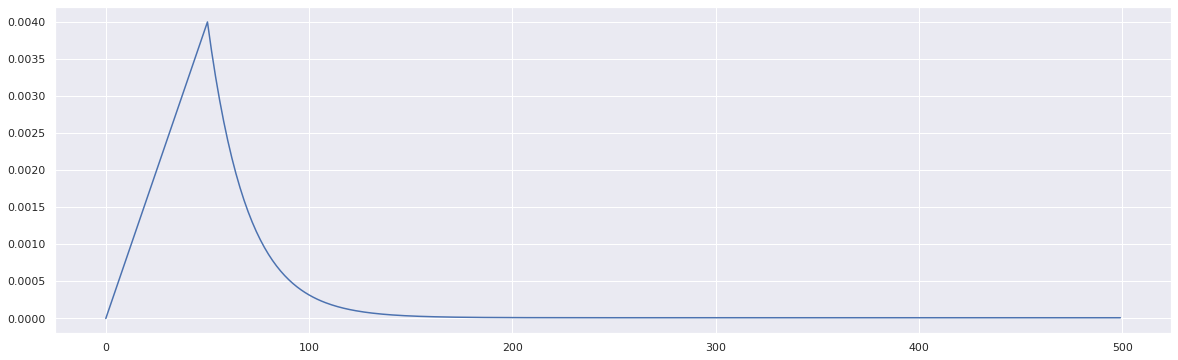

In [83]:
"""dump lr
"""
ep_num_transf = 500



def lrdump(epoch):
    
    #step_size = 100
    lr_max = 0.004
    lr_min = 0.00001
    lr_start = 0.00001

    lr_init_ep = 0
    lr_ramp_ep = 50
    lr_sus_ep  = 0 #10
    lr_decay   = 0.95

    
    # warm up
    if epoch < lr_init_ep:
        lr = (lr_max - lr_min) / lr_ramp_ep * epoch + lr_min    
        
    elif lr_init_ep -1 < epoch < lr_ramp_ep:
        lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start

    elif epoch < lr_ramp_ep + lr_sus_ep:
        lr = lr_max

    else:
        lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min

    return lr

rng = [i for i in range(ep_num_transf)]
y = [lrdump(x) for x in rng]
sns.set(style='darkgrid')
fig, ax = plt.subplots(figsize=(20, 6))
plt.plot(rng, y)

In [84]:
print('{} ~ {}'.format(min(y), max(y)))

1e-07 ~ 0.004


In [85]:
for e, lr in zip(rng,y):
    print('{}\t {}\n'.format(e, lr))

0	 1e-07

1	 8.0098e-05

2	 0.000160096

3	 0.000240094

4	 0.000320092

5	 0.00040009

6	 0.000480088

7	 0.000560086

8	 0.000640084

9	 0.0007200819999999999

10	 0.00080008

11	 0.000880078

12	 0.0009600759999999999

13	 0.001040074

14	 0.0011200720000000002

15	 0.0012000700000000001

16	 0.001280068

17	 0.001360066

18	 0.001440064

19	 0.0015200620000000002

20	 0.0016000600000000002

21	 0.0016800580000000001

22	 0.001760056

23	 0.001840054

24	 0.001920052

25	 0.0020000499999999997

26	 0.0020800479999999997

27	 0.002160046

28	 0.002240044

29	 0.002320042

30	 0.00240004

31	 0.002480038

32	 0.002560036

33	 0.002640034

34	 0.002720032

35	 0.00280003

36	 0.0028800279999999998

37	 0.0029600259999999997

38	 0.003040024

39	 0.003120022

40	 0.00320002

41	 0.003280018

42	 0.003360016

43	 0.003440014

44	 0.003520012

45	 0.00360001

46	 0.003680008

47	 0.0037600059999999998

48	 0.0038400039999999997

49	 0.0039200020000000006

50	 0.004

51	 0.0038005000000000

In [86]:
# lr_reduceonplateau = tf.keras.callbacks.ReduceLROnPlateau(monitor=monitor, factor=0.1, patience=5, verbose=1, mode='auto', min_delta=0.0001, cooldown=0, min_lr=1e-12)

In [87]:
# Callback for printing the LR at the end of each epoch.
class PrintLRtoe(tf.keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs=None):
#     def on_epoch_end(self, epoch, logs=None):
#         print('\n[{}] Learning rate for epoch {} is {}'.format(
#             datetime.now().strftime("%Y%m%d-%H%M-%S"), 
#             epoch + 1,
#             self.model.optimizer.lr.numpy()))
        print('\n[{}] Learning rate for epoch {} is {}'.format(
        datetime.now().strftime("%Y%m%d-%H%M-%S"), 
        epoch + 1,
        model_toe.optimizer._decayed_lr(tf.float32).numpy()))

In [88]:
# Callback for printing the LR at the end of each epoch.
class PrintLRheel(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
#         print('\nLearning rate for epoch {} is {}'.format(epoch + 1,
#                                               model_heel.optimizer.lr.numpy()))
        print('\n[{}] Learning rate for epoch {} is {}'.format(
        datetime.now().strftime("%Y%m%d-%H%M-%S"), 
        epoch + 1,
        model_heel.optimizer._decayed_lr(tf.float32).numpy()))

### Output dir and models

In [89]:
def mk_log_dir(log_dir_name):
    try:
        os.makedirs(log_dir_name)
    except OSError as e:
        print("This log dir exist.")
        if e.errno != errno.EEXIST:
            raise ValueError("we got problem.")

In [90]:
monitor = 'val_loss' #'val_loss' 'val_accuracy' if use ed_loss it still the loss here.

log_dir_name = datetime.now().strftime("%Y%m%d-%H%M%S") 

# mk_log_dir(datetime.now().strftime("%Y%m%d-%H%M%S") )  

In [91]:
# use once at the time
mk_log_dir(log_dir_name)

# Toe

In [92]:
# model_name = 'EfficientNetB0'

# model_name = 'EfficientNetB1'

# 2021-11-05 test
# model_name = 'EfficientNetB3'

# model_name = 'EfficientNetB7'


# model_name = 'VGG16'

# model_name = 'Xception'

# model_name = "ResNet50"


# 0-6
Model_List = ["Xception", "ResNet50", "ResNet101", "ResNet152", "InceptionV3", "MobileNet", "MobileNetV2", 
"DenseNet121","DenseNet169","DenseNet201", # 7 8 9
"NASNetMobile","NASNetLarge", # 10 11 (hard code of size!224 331!)
"EfficientNetB0",
"EfficientNetB1", #13
"EfficientNetB3",
"EfficientNetB5", #15
"EfficientNetB7",
'VGG16', # 17
'VGG19', # 18
]

model_name = Model_List[18]
# print(Model_List[1:3])
print(model_name)

VGG19


In [93]:
#get_best_model_name

# best_model_name = './' + model_name + '_bs-' + str(BATCH_SIZE) + '_s-' + str(img_height) + '_' + "ep-{epoch:02d}-vloss-{val_loss:.2f}" +'_best-weight.h5'
# best_model_name = '{model_name}-ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5'
#best_model_name = './' + model_name + '_bs' + str(BATCH_SIZE) + '_w' + str(img_width) + '_' + monitor + '_best.h5'
# best_model_name = './Leaf_' + model_name + '_bs' + str(BATCH_SIZE) + '_w' + str(img_width) + '_' + datetime.now().strftime("%Y%m%d-%H%M%S") + '_best_' + monitor + '.h5'

# best_model_name = './cop' + model_name + '_bs' + str(BATCH_SIZE) + '_w' + str(img_width) + '_' + datetime.now().strftime("%Y%m%d-%H%M%S") + '_best_' + monitor + '.h5'

def get_best_model_name(th):
    return './' + log_dir_name + '/' + th + '_' + model_name + '_bs' + str(BATCH_SIZE) + '_w' + str(img_width) + '_best_' + monitor + '.h5'

th = 'toe'
# th = 'heel'

print(get_best_model_name(th))

best_model_name = get_best_model_name(th)


best_model_save = tf.keras.callbacks.ModelCheckpoint(filepath=best_model_name, 
                             save_best_only = True, 
                             save_weights_only = False,
                             monitor = monitor, 
                             mode = 'auto', verbose = 1)
print('best_model_name:', best_model_name)

./20211117-165117/toe_VGG19_bs64_w120_best_val_loss.h5
best_model_name: ./20211117-165117/toe_VGG19_bs64_w120_best_val_loss.h5


In [94]:
""" TensorBoard callback will slowdown the training.
tf.keras.callbacks.TensorBoard(
    log_dir='logs', histogram_freq=0, write_graph=True,
    write_images=False, write_steps_per_second=False, update_freq='epoch',
    profile_batch=2, embeddings_freq=0, embeddings_metadata=None, **kwargs
)
"""

logdir = log_dir_name + "/logs/toe/"

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [95]:
# create keras model

# model_name = 'EfficientNetB0'

# top_dropout_rate = 0.8 #less dp rate, say 0.1, train_loss will lower than val_loss
# drop_connect_rate = 0.9 #for efnet This parameter serves as a toggle for extra regularization in finetuning, but does not affect loaded weights.
# outputnum = 2

# with strategy.scope():
    
#     base_model = tf.keras.applications.EfficientNetB0(include_top=False, weights="imagenet",drop_connect_rate=drop_connect_rate) #{'imagenet', None}

#     # Freeze the pretrained weights
#     base_model.trainable = False
#     print("base_model.trainable : ", base_model.trainable)

#     # Rebuild top
#     gap2d = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
#     BNL = tf.keras.layers.BatchNormalization()(gap2d) #tood: remove#
#     dropout = tf.keras.layers.Dropout(top_dropout_rate)(BNL)#tood: remove# J add dropout, for flood 0.2 is ok. for leaf 0.4 is better.
#     outputs = tf.keras.layers.Dense(2)(dropout)# remove activation for regression output (to default, the linear), , activation = 'relu' no help

#     # Compile new model
#     model_toe = tf.keras.Model(base_model.input, outputs, name=model_name)


#     # unfreeze the top #fine_tune_at# layers while leaving BatchNorm layers frozen
#     fine_tune_at = 20 #10 #241 #20
#     print('[Note] Now create model fine tuneing at Top-{} layers!'.format(fine_tune_at))
#     for layer in model_toe.layers[-fine_tune_at:]:
#         if not isinstance(layer, tf.keras.layers.BatchNormalization):
#             layer.trainable = True

#     model_toe.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),#RMSprop , Adam, SGD Adadelta(learning_rate=0.001), if set lr_callback the learning_rate=0.001 will not effeced.
#                     loss=ed_metric_2d_mean)
#                       #metrics=[tf.keras.metrics.MeanSquaredError()])
#                       #metrics=[edRescal])
    
# #     loss=tf.keras.losses.MeanSquaredError()
#                     #ed_metric_2d_mean,#, ed_loss ed_metric_2d ed_metric_2d_mean            
#                     #metrics=['mae', 'accuracy'])#!!note!! for keypoint regression should use MSE loss 01/29#
        



# # # AdaBeliefOptimizer(learning_rate=1e-3, epsilon=1e-14, rectify=False)
# # model_toe.compile(optimizer = AdaBeliefOptimizer(learning_rate=1e-3, epsilon=1e-14, rectify=False),#RMSprop , Adam, SGD Adadelta(learning_rate=0.001), if set lr_callback the learning_rate=0.001 will not effeced.
# #                 loss=ed_metric_2d_mean)#,#, ed_loss ed_metric_2d ed_metric_2d_mean            
# #                 #metrics=['mae', 'accuracy'])


# # =========================================================================================================






# Transfer learning from pre-trained weights
# def build_efn_model(outputnum, top_dropout_rate, drop_connect_rate):
#     base_model = tf.keras.applications.EfficientNetB0(include_top=False, weights="imagenet", input_shape=(120,120,3),drop_connect_rate=drop_connect_rate) #{'imagenet', None}

    
#     # Freeze the pretrained weights
#     base_model.trainable = False
#     print("base_model.trainable : ", base_model.trainable)

#     # Rebuild top
#     gap2d = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
#     BNL = tf.keras.layers.BatchNormalization()(gap2d) #tood: remove#
#     dropout = tf.keras.layers.Dropout(top_dropout_rate)(BNL)#tood: remove# J add dropout, for flood 0.2 is ok. for leaf 0.4 is better.
#     outputs = tf.keras.layers.Dense(outputnum)(dropout)# remove activation for regression output (to default, the linear), , activation = 'relu' no help

#     # Compile new model
#     model = tf.keras.Model(base_model.input, outputs, name=model_name)


# #     # unfreeze the top #fine_tune_at# layers while leaving BatchNorm layers frozen
# #     fine_tune_at = 20 #10 #241 #20
# #     print('[Note] Now create model fine tuneing at Top-{} layers!'.format(fine_tune_at))
# #     for layer in model_toe.layers[-fine_tune_at:]:
# #         if not isinstance(layer, tf.keras.layers.BatchNormalization):
# #             layer.trainable = True

#     model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),#RMSprop , Adam, SGD Adadelta(learning_rate=0.001), if set lr_callback the learning_rate=0.001 will not effeced.
#                     loss=ed_metric_2d_mean)

    
#     return model



# # =========================================================================================================
# 2021-11-08 
# 2021-11-12 give "model_name" arg

# # Test base_model(inputs, training=False)
# def build_efn_model(model_name, outputnum, top_dropout_rate, drop_connect_rate):
#     base_model = tf.keras.applications.EfficientNetB0(include_top=False, weights="imagenet", input_shape=(120,120,3),drop_connect_rate=drop_connect_rate) #{'imagenet', None}

    
#     # Freeze the pretrained weights
#     base_model.trainable = False
#     print("base_model.trainable : ", base_model.trainable)

#     # How to add training=False in base_model create
#     inputs = tf.keras.Input(shape=(120, 120, 3))
#     b_m_output = base_model(inputs, training=False)
    
#     # Rebuild top
#     gap2d = tf.keras.layers.GlobalAveragePooling2D()(b_m_output) #(base_model.output)
#     #BNL = tf.keras.layers.BatchNormalization()(gap2d) #tood: remove#
#     dropout = tf.keras.layers.Dropout(top_dropout_rate)(gap2d)#tood: remove# J add dropout, for flood 0.2 is ok. for leaf 0.4 is better.
#     outputs = tf.keras.layers.Dense(outputnum)(dropout)# remove activation for regression output (to default, the linear), , activation = 'relu' no help

#     # Compile new model
#     model = tf.keras.Model(inputs, outputs, name=model_name)


# #     # unfreeze the top #fine_tune_at# layers while leaving BatchNorm layers frozen
# #     fine_tune_at = 20 #10 #241 #20
# #     print('[Note] Now create model fine tuneing at Top-{} layers!'.format(fine_tune_at))
# #     for layer in model_toe.layers[-fine_tune_at:]:
# #         if not isinstance(layer, tf.keras.layers.BatchNormalization):
# #             layer.trainable = True

#     model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),#RMSprop , Adam, SGD Adadelta(learning_rate=0.001), if set lr_callback the learning_rate=0.001 will not effeced.
#                     loss=ed_metric_2d_mean)

    
#     return model, base_model

In [96]:
# # dynamic load models


#目前沒有解法以字串或變數方法建立模型 先手寫每個模式以後再找解法>>有解如下 但是行數會變多喔
#normal usage
# model = tensorflow.keras.applications.efficientnet.EfficientNetB0() 
# model = tf.keras.applications.EfficientNetB0(include_top=False, weights="imagenet", input_shape=(120,120,3),drop_connect_rate=drop_connect_rate) #{'imagenet', None}



# import importlib 
# import pkgutil

# for finder, name, _ in pkgutil.iter_modules(['/usr/local/lib/python3.8/dist-packages/tensorflow/keras/applications/']):
#     print('module root:{}, model_sub:{}'.format(finder.path, name))
#     try:
#         importlib.import_module('{}.{}'.format(finder.path, name))
#         print('module root:{}, model_sub:{}'.format(finder.path, name))
#     except Exception as e:
#         print('Can not import {}'.format(name))
        
        
# model_name = 'EfficientNetB0'
# module_path = 'tensorflow.keras.applications.efficientnet'
# # module_path = '/usr/local/lib/python3.8/dist-packages/tensorflow/keras/applications/'
# model = importlib.import_module(module_path, model_name)   

# model = tf.keras.Model(model.input, model.output, name=model_name)
# model = tf.keras.Model(model, name=model_name)
# model.build() # has no attribute 'build'
# model.summary() # has no attribute 'summary'

In [97]:
"""
aps: module 'tensorflow.keras.applications' from '/usr/local/lib/python3.8/dist-packages/tensorflow/keras/applications/__init__.py
vim /usr/local/lib/python3.8/dist-packages/tensorflow/keras/applications/__init__.py

可以實現由動態字串變數載入特定的基本模型<但是太多處理>還不如直接表列每項寫出來的清楚簡單!!!!

Model_List = ["Xception", "ResNet50", "ResNet101", "ResNet152", "InceptionV3", "MobileNet", "MobileNetV2", 
"DenseNet121","DenseNet169","DenseNet201",
"NASNetMobile","NASNetLarge", 
"EfficientNetB0",
"EfficientNetB1", #13
"EfficientNetB3",
"EfficientNetB5", #15
"EfficientNetB7",
]
"""
import importlib 



    
def build_efn_model(model_name, outputnum, top_dropout_rate, drop_connect_rate):
    
    # move to Top 
    inputs = tf.keras.Input(shape=(120, 120, 3))
    
    # EfficientNetB@# #
#     # OK efn
#     if model_name.startswith('EfficientNetB'):# == "EfficientNetB0":
#         root_m_name = 'efficientnet'
#         fullnameofmodel = "tensorflow.keras.applications." + root_m_name #model_name #model_name.lower()
#         model = importlib.import_module(fullnameofmodel)
#         BaseCnn = getattr(model,model_name)       
#         base_model = BaseCnn(include_top=False, weights="imagenet", input_shape=(120,120,3),drop_connect_rate=drop_connect_rate) #{'imagenet', None}
    # shorter version of OK efn
    if model_name.startswith('EfficientNetB'):
        """For EfficientNet, input preprocessing is included as part of the model (as a Rescaling layer)."""
        BaseCnn = getattr(importlib.import_module("tensorflow.keras.applications.efficientnet"), model_name)       
        base_model = BaseCnn(include_top=False, weights="imagenet", input_shape=(120,120,3),drop_connect_rate=drop_connect_rate) #{'imagenet', None}
        # NO extra rescale need, efn already include the scaling inside the model
        rescaling_input = inputs
        
    # Xception #
    """When run in "tf" mode it actuallly expect the input to be uint8 between 0 and 255 and scales it to the range from -1.0 to 1.0. 
    Check the docstring and the source code.""" #NOT TRUE
    """ For Xception, call tf.keras.applications.xception.preprocess_input on your inputs before passing them to the model. 
    xception.preprocess_input will scale input pixels between -1 and 1."""
    if model_name.startswith('Xception'):
        BaseCnn = getattr(importlib.import_module("tensorflow.python.keras.applications.xception"), model_name)     
        base_model = BaseCnn(include_top=False, weights="imagenet", input_shape=(120,120,3)) #{'imagenet', None}
        
        rescaling_input = tf.keras.applications.xception.preprocess_input(inputs)

    # ResNet50 ResNet101 ResNet152 #
    if model_name.startswith('ResNet'):
        """For ResNet, call tf.keras.applications.resnet.preprocess_input on your inputs before passing them to the model. 
        resnet.preprocess_input will convert the input images from RGB to BGR, then will zero-center each color channel with 
        respect to the ImageNet dataset, without scaling."""
        BaseCnn = getattr(importlib.import_module("tensorflow.python.keras.applications.resnet"), model_name)     
        base_model = BaseCnn(include_top=False, weights="imagenet", input_shape=(120,120,3)) #{'imagenet', None}    
        
        rescaling_input = tf.keras.applications.resnet.preprocess_input(inputs)
        
    # InceptionV3 #
    if model_name.startswith('InceptionV3'):
        """For InceptionV3, call tf.keras.applications.inception_v3.preprocess_input on your inputs before passing them to the model. 
        inception_v3.preprocess_input will scale input pixels between -1 and 1."""
        BaseCnn = getattr(importlib.import_module("tensorflow.python.keras.applications.inception_v3"), model_name)     
        base_model = BaseCnn(include_top=False, weights="imagenet", input_shape=(120,120,3)) #{'imagenet', None}    
        
        rescaling_input = tf.keras.applications.inception_v3.preprocess_input(inputs)        

    # MobileNet #
    if model_name.endswith('MobileNet'):
        """ For MobileNet, call tf.keras.applications.mobilenet.preprocess_input on your inputs before passing them to the model. 
        mobilenet.preprocess_input will scale input pixels between -1 and 1."""
        BaseCnn = getattr(importlib.import_module("tensorflow.python.keras.applications.mobilenet"), model_name)     
        base_model = BaseCnn(include_top=False, weights="imagenet", input_shape=(120,120,3)) #{'imagenet', None}    
        
        rescaling_input = tf.keras.applications.mobilenet.preprocess_input(inputs)             
        
    # MobileNetV2 #
    if model_name.startswith('MobileNetV2'):
        """ For MobileNetV2, call tf.keras.applications.mobilenet_v2.preprocess_input on your inputs before passing them to the model. 
        mobilenet_v2.preprocess_input will scale input pixels between -1 and 1."""
        BaseCnn = getattr(importlib.import_module("tensorflow.python.keras.applications.mobilenet_v2"), model_name)     
        base_model = BaseCnn(include_top=False, weights="imagenet", input_shape=(120,120,3)) #{'imagenet', None}    
        
        rescaling_input = tf.keras.applications.mobilenet_v2.preprocess_input(inputs)            
        
    # DenseNet121 DenseNet169 DenseNet201 #
    if model_name.startswith('DenseNet'):
        """ For DenseNet, call tf.keras.applications.densenet.preprocess_input on your inputs before passing them to the model."""
        BaseCnn = getattr(importlib.import_module("tensorflow.python.keras.applications.densenet"), model_name)     
        base_model = BaseCnn(include_top=False, weights="imagenet", input_shape=(120,120,3)) #{'imagenet', None}    
        
        rescaling_input = tf.keras.applications.densenet.preprocess_input(inputs)            
        
    # NASNetMobile NASNetLarge #
    if model_name.startswith('NASNet'):
        """For NASNet, call tf.keras.applications.nasnet.preprocess_input on your inputs before passing them to the model."""
        """Optional shape tuple, only to be specified if include_top is False (otherwise the input shape has to be (224, 224, 3)
        for NASNetMobile It should have exactly 3 inputs channels, and width and height should be no smaller than 32. E.g. (224, 224, 3) 
        would be one valid value. For loading imagenet weights, input_shape should be (224, 224, 3)"""
        """otherwise the input shape has to be (331, 331, 3) for NASNetLarge. It should have exactly 3 inputs channels, and width and height should 
        be no smaller than 32. E.g. (224, 224, 3) would be one valid value.  For loading imagenet weights, input_shape should be (331, 331, 3)"""
        """ NASNetMobile imagenet with 224: ted 10.x/5.x 
            NASNetMobile None with 120: ted 12.x/4.x,  seem no different at fine tune phase. """
        BaseCnn = getattr(importlib.import_module("tensorflow.python.keras.applications.nasnet"), model_name)     
#         base_model = BaseCnn(include_top=False, weights="imagenet") #{'imagenet', None}    
        base_model = BaseCnn(include_top=False, weights=None, input_shape=(120,120,3)) #{'imagenet', None} for set input to 120x120    

#         inputs = tf.keras.layers.Resizing(224, 224) # tf >= 2.6.0, but currnet TWCC newest 21.08 is tf=2.5.0
        inputs = tf.keras.Input([None, None, 3])
#         i = tf.compat.v1.keras.layers.experimental.preprocessing.Resizing(224, 224)(inputs)
#         x = tf.cast(i, tf.float32)

        rescaling_input = tf.keras.applications.nasnet.preprocess_input(inputs)            
        
        
        
    # VGG16 #
    """VGG16 not train even with None or Imagenet. pooling= is not the factor"""
    if model_name.startswith('VGG16'):
        """For VGG16, call tf.keras.applications.vgg16.preprocess_input on your inputs before passing them to the model. 
        vgg16.preprocess_input will convert the input images from RGB to BGR, then will zero-center each color channel 
        with respect to the ImageNet dataset, without scaling."""
        BaseCnn = getattr(importlib.import_module("tensorflow.python.keras.applications.vgg16"), model_name)     
        base_model = BaseCnn(include_top=False, weights=None, input_shape=(120,120,3)) #{'imagenet', None}    
        
        rescaling_input = tf.keras.applications.vgg16.preprocess_input(inputs)  
        
    # VGG19 #
    if model_name.startswith('VGG19'):
        """For VGG19, call tf.keras.applications.vgg19.preprocess_input on your inputs before passing them to the model. 
        vgg16.preprocess_input will convert the input images from RGB to BGR, then will zero-center each color channel 
        with respect to the ImageNet dataset, without scaling."""
        
        BaseCnn = getattr(importlib.import_module("tensorflow.python.keras.applications.vgg19"), model_name)     
        base_model = BaseCnn(include_top=False, weights="imagenet", input_shape=(120,120,3)) #{'imagenet', None}    
        
        rescaling_input = tf.keras.applications.vgg16.preprocess_input(inputs)  
        

#     # template #
#     if model_name.startswith(''):
#         """For."""
#         BaseCnn = getattr(importlib.import_module("tensorflow.python.keras.applications."), model_name)     
#         base_model = BaseCnn(include_top=False, weights="imagenet", input_shape=(120,120,3)) #{'imagenet', None}    
        
#         rescaling_input = tf.keras.applications.inception_v3.preprocess_input(inputs)  


#     # template #
#     if model_name.startswith(''):
#         """For."""
#         BaseCnn = getattr(importlib.import_module("tensorflow.python.keras.applications."), model_name)     
#         base_model = BaseCnn(include_top=False, weights="imagenet", input_shape=(120,120,3)) #{'imagenet', None}    
        
#         rescaling_input = tf.keras.applications.inception_v3.preprocess_input(inputs)  


        
    # Freeze the pretrained weights
    base_model.trainable = False
    print("base_model.trainable : ", base_model.trainable)
    
# move to Top 
    # How to add training=False in base_model create
    #inputs = tf.keras.Input(shape=(120, 120, 3))
    #rescal = rescaling_input()(inputs)
    #b_m_output = base_model(inputs, training=False)
    
    b_m_output = base_model(rescaling_input, training=False)
    
    # Rebuild top
    gap2d = tf.keras.layers.GlobalAveragePooling2D()(b_m_output) #(base_model.output)
    #BNL = tf.keras.layers.BatchNormalization()(gap2d) #tood: remove#
    dropout = tf.keras.layers.Dropout(top_dropout_rate)(gap2d)#tood: remove# J add dropout, for flood 0.2 is ok. for leaf 0.4 is better.
    outputs = tf.keras.layers.Dense(outputnum)(dropout)# remove activation for regression output (to default, the linear), , activation = 'relu' no help

    # Compile new model
    model = tf.keras.Model(inputs, outputs, name=model_name)

    model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),#RMSprop , Adam, SGD Adadelta(learning_rate=0.001), if set lr_callback the learning_rate=0.001 will not effeced.
                loss=ed_metric_2d_mean)
    
    return model, base_model
    
    
########
# ap = tf.keras.applications
# print(ap)

# from tensorflow.keras.applications as ap
# ap.applications["EfficientNetB0"]


# import tensorflow
# import importlib 
# print(model_name)
# ap_name = "tensorflow.keras.applications.efficientnet." + model_name
# b_model = importlib.import_module(model_name, package="/usr/local/lib/python3.8/dist-packages/tensorflow/keras/applications/efficientnet/")# from tensorflow.python.keras.applications import model_name
# b_model = importlib.import_module(model_name, tf.keras.applications.efficientnet)# from tensorflow.python.keras.applications import model_name
# b_model = importlib.import_module(".EfficientNetB0", 'tensorflow.keras.applications.efficientnet')# from tensorflow.python.keras.applications import model_name
# b_model = importlib.import_module(ap_name)
# b_model = importlib.import_module('/usr/local/lib/python3.8/dist-packages/tensorflow/keras/applications/efficientnet/')


# # work but why
# import http as h
# name = h.__name__
# print(name)
# c = importlib.import_module('.client', name) #ok
# c = importlib.import_module('.client', "http") #ok

In [98]:
callbacks = [
#     tensorboard_callback,
    best_model_save,
    tf.keras.callbacks.EarlyStopping(monitor=monitor, patience=patience_toe_1), #patience=step_size or ep_num
#     lr_reduceonplateau,
    tf.keras.callbacks.LearningRateScheduler(lrdump),#lrdump, decay or lrfn or lrfn2. clr
    PrintLRtoe()
]

In [99]:
top_dropout_rate = 0.8 #less dp rate, say 0.1, train_loss will lower than val_loss
drop_connect_rate = 0.9 #for efnet This parameter serves as a toggle for extra regularization in finetuning, but does not affect loaded weights.
outputnum = 2
# with strategy.scope():
    # Model building/compiling need to be within `strategy.scope()`.
model_toe, base_model = build_efn_model(model_name, outputnum, top_dropout_rate, drop_connect_rate) # for efnet, Xincept


base_model.trainable :  False


In [100]:
len(model_toe.layers)

7

In [101]:
tt = 0
nt = 0
for layer in model_toe.layers:
    if layer.trainable:
        tt +=1
        print(f'{layer.name}')
    else:
        nt +=1
print(f'tt: {tt}, nt:{nt}')

input_1
tf.__operators__.getitem
tf.nn.bias_add
global_average_pooling2d
dropout
dense
tt: 6, nt:1


In [102]:
def count_model_trainOrNot_layers(model, printlayers=False):
    tt = 0
    nt = 0
    for layer in model.layers:
        if layer.trainable:
            tt +=1
            if printlayers:
                print(f'{layer.name}')
        else:
            nt +=1
    print(f'tt: {tt}, nt:{nt}, total layers:{tt+nt}')

In [103]:
count_model_trainOrNot_layers(model_toe)

tt: 6, nt:1, total layers:7


In [104]:
model_toe.summary()

Model: "VGG19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 120, 120, 3)]     0         
_________________________________________________________________
tf.__operators__.getitem (Sl (None, 120, 120, 3)       0         
_________________________________________________________________
tf.nn.bias_add (TFOpLambda)  (None, 120, 120, 3)       0         
_________________________________________________________________
vgg19 (Functional)           (None, 3, 3, 512)         20024384  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 2)                 1026  

In [105]:
#base_model.summary()

In [ ]:
%%time

# fit the model on all data
history_toe = model_toe.fit(train_ds_pre_toe_s, 
                      verbose=1, 
                      epochs=ep_num_transf, 
                      validation_data=valid_ds_pre_toe_s, 
                      callbacks=callbacks)#, validation_split=0.1)

Epoch 1/500

[20211117-1651-18] Learning rate for epoch 1 is 1.0000000116860974e-07
 2/15 [===>..........................] - ETA: 6s - loss: 83.3143 

In [ ]:
#     [20210225-1412-53] Learning rate for epoch 61 is 0.007600000128149986
#     Epoch 61/500
#     16/17 [===========================>..] - ETA: 0s - loss: 13.2744
#     Epoch 00061: val_loss did not improve from 10.24748
#     17/17 [==============================] - 0s 24ms/step - loss: 13.3174 - val_loss: 10.4282
#     CPU times: user 5min 52s, sys: 1min 5s, total: 6min 57s
#     Wall time: 3min 26s
    
    
#     [20211102-0741-52] Learning rate for epoch 75 is 0.007040000054985285
#     17/17 [==============================] - 3s 36ms/step - loss: 13.3929 - val_loss: 9.7654

#     Epoch 00075: val_loss did not improve from 9.72551
#     CPU times: user 11min 36s, sys: 2min 43s, total: 14min 20s
#     Wall time: 3min 20s

In [ ]:
"""train split有區域最小的問題，相同ds但最佳收斂點不同！"""
"""KFold split may have same issue."""

In [ ]:
# model_toe.summary()

In [ ]:
# tf.keras.utils.plot_model(model_toe, show_shapes=True)

In [ ]:
# show after modl.fit
model_toe.metrics_names

In [ ]:
# check metrics the model have.
history_toe.history.keys()

In [ ]:
# check the loos the model trained.
plt.figure(figsize=(25, 10))
plt.plot(history_toe.history['loss'])
plt.plot(history_toe.history['val_loss'])
plt.title('model ed loss')
plt.ylabel('ed loss'), plt.ylim(5, 20)# for too large loss
plt.xlabel('epoch')
plt.legend(['loss', 'val_loss'], loc='upper left') 
# plt.show()

# save plot : comment plo.show in jupyter notebook.
plt.savefig(f'{log_dir_name}_toe_tl.png', bbox_inches = 'tight')

In [ ]:
# check the loos the model trained.

# for different scales (different Y-axes)
# fig, ax1 = plt.subplots()
fig, ax1 = plt.subplots(figsize=(25, 10))

# nice to have this colorful tip.
color = 'tab:red'

ax1.set_title('model ed loss')

ax1.set_xlabel('epoch')
ax1.set_ylabel('ed loss', color=color)

ax1.plot(history_toe.history['loss'])
ax1.plot(history_toe.history['val_loss'])
ax1.tick_params(axis='y', labelcolor=color)
ax1.legend(['loss', 'val_loss'], loc='upper center') # legend may ocvered by next ax ploting. moved to end.


ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('learning rate', color=color)
ax2.plot(history_toe.history['lr'], color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.legend(['lr'], loc='upper right') 

# plt.show()


# save plot : comment plo.show in jupyter notebook.
def get_valloss(his_v_l):   
    return np.min(his_v_l), np.argmin(his_v_l)

vl, ep = get_valloss(history_toe.history['val_loss'])
plt.savefig(f'{log_dir_name}_toe_tl_clr_ed{round(vl,4)}@{ep}.png', bbox_inches = 'tight')

## Toe Fine-Tuning

In [ ]:
# ep_num = 1000

# def warmup_CosineDecayRestarts(epoch):
#     initial_learning_rate = 1e-5
#     first_decay_steps = 500
    
#     lr_decayed_fn = (
#       tf.keras.optimizers.schedules.CosineDecayRestarts(
#           initial_learning_rate,
#           first_decay_steps))
        
#     # warm up
#     step_size = 25 # currently best for foot pp
#     max_lr = initial_learning_rate #0.01 # currently best for foot pp
#     base_lr = 1e-8 # 1e-6 1e-7

#     # warm up
#     lr_init_ep = 0
#     lr_ramp_ep = 50
#     lr_sus_ep  = 0
#     lr_decay   = 0.5
#     if epoch < lr_ramp_ep:
#         lr = (max_lr - base_lr) / lr_ramp_ep * epoch + base_lr
    
#     else:
#         lr = lr_decayed_fn(epoch)

#     return lr


# ep_num_transf = 500
# rng = [i for i in range(ep_num_transf)]
# y = [warmup_CosineDecayRestarts(x) for x in rng]
# sns.set(style='darkgrid')
# fig, ax = plt.subplots(figsize=(20, 6))
# plt.plot(rng, y)

In [ ]:
# # clr3
# # warm up 10% of epoch: it can reduce fall in local min in inital steps.


# ep_num = 1000



# def clr3(epoch):
    
    
#     step_size = 25 # currently best for foot pp
#     max_lr = 0.01 # currently best for foot pp
#     base_lr = 1e-6 # 1e-6 1e-7

#     # warm up
#     lr_init_ep = 0
#     lr_ramp_ep = 100
#     lr_sus_ep  = 0
#     lr_decay   = 0.5

#     iterations = epoch
#     cycle = np.floor(1+iterations/(2*step_size))
#     x = np.abs(iterations/step_size - 2*cycle + 1)
#     lr = base_lr + (max_lr-base_lr)*np.maximum(0, (1-x))
    
#     #todo: boost the lr at initial setps.
# #     initial_lr = lambda epoch: lr if epoch > step_size else max_lr
# #     initial_lr = lambda epoch: lr if epoch > step_size else boost_lr
# #     lr = initial_lr(epoch)
#     #todo: boost the lr at fist step_size.
    
#     # warm up
#     if epoch < lr_ramp_ep:
#         lr = (max_lr - base_lr) / lr_ramp_ep * epoch + base_lr
    
#     decay = ((epoch+1)/ep_num)
#     base_part = 1.001 #1.1
# #     print(decay)
#     return lr * (base_part-decay) * lr_decay # supressed the lr!


# rng = [i for i in range(ep_num)]
# y = [clr3(x) for x in rng]
# sns.set(style='darkgrid')
# fig, ax = plt.subplots(figsize=(20, 6))
# plt.plot(rng, y)

In [ ]:
# """dump lr lower e5
# """
# ep_num_transf = 500



# def lrdump_lower_e5(epoch):
    
#     #step_size = 100
#     lr_max = 0.0004
#     lr_min = 0.000001
#     lr_start = 0.000001

#     lr_init_ep = 0
#     lr_ramp_ep = 50
#     lr_sus_ep  = 0 #10
#     lr_decay   = 0.95

    
#     # warm up
#     if epoch < lr_init_ep:
#         lr = (lr_max - lr_min) / lr_ramp_ep * epoch + lr_min    
        
#     elif lr_init_ep -1 < epoch < lr_ramp_ep:
#         lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start

#     elif epoch < lr_ramp_ep + lr_sus_ep:
#         lr = lr_max

#     else:
#         lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min

#     return lr

# rng = [i for i in range(ep_num_transf)]
# y = [lrdump(x) for x in rng]
# sns.set(style='darkgrid')
# fig, ax = plt.subplots(figsize=(20, 6))
# plt.plot(rng, y)

In [ ]:
print('{} ~ {}'.format(min(y), max(y)))

In [ ]:
# """lr from kaggle leaf"""
# ep_num = 1000



# def lrfn2(epoch):
    
#     lr_start   = 0.000005
#     # lr_max     = 0.00000125 * strategy.num_replicas_in_sync * BATCH_SIZE
#     lr_max     = 0.001
#     lr_min     = 0.000001
#     lr_ramp_ep = 50
#     lr_sus_ep  = 20
#     lr_decay   = 0.95


#     if epoch < lr_ramp_ep:
#         lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start

#     elif epoch < lr_ramp_ep + lr_sus_ep:
#         lr = lr_max

#     else:
#         lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min

#     return lr



# rng = [i for i in range(ep_num)]
# y = [lrfn2(x) for x in rng]
# sns.set(style='darkgrid')
# fig, ax = plt.subplots(figsize=(20, 6))
# plt.plot(rng, y)

In [ ]:
print('{} ~ {}'.format(min(y), max(y)))

In [ ]:
def unfreeze_model(model, base_model):
#     # We unfreeze the top 20 layers while leaving BatchNorm layers frozen
#     for layer in model.layers[-20:]:
#         if not isinstance(layer, layers.BatchNormalization):
#             layer.trainable = True

#     model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),#RMSprop , Adam, SGD Adadelta(learning_rate=0.001), if set lr_callback the learning_rate=0.001 will not effeced.





#     fine_tune_at = 20 #10 #241 #20
#     print('[Note] Now create model fine tuneing at Top-{} layers!'.format(fine_tune_at))
#     for layer in model_toe.layers[-fine_tune_at:]:
#         if not isinstance(layer, tf.keras.layers.BatchNormalization):
#             layer.trainable = True


#
#'block7a_expand_conv'20 'block6c_expand_conv'50 'block6a_expand_conv'79 'block5b_expand_conv'109 'block4a_expand_conv' 166 
#

    # Set All layers trainable first
    #model.trainable = True #範例似乎是指 base_model.trainable = True 而不是新建model！！！！！！(2021-11-08)
    base_model.trainable = True
    
    
    
    # Then, set layers NOT trainable below specific layer.
#     set_trainable = False
#     for layer in model.layers:
#         if layer.name == 'block5b_expand_conv': 
#             set_trainable = True
#         if set_trainable:
#             layer.trainable = True
#         else:
#             layer.trainable = False

    model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),#RMSprop , Adam, SGD Adadelta(learning_rate=0.001), if set lr_callback the learning_rate=0.001 will not effeced.
                    loss=ed_metric_2d_mean)


In [ ]:
# unfreeze for finetune the toe model  
unfreeze_model(model_toe,base_model)

In [ ]:
count_model_trainOrNot_layers(model_toe)

In [ ]:
callbacks = [
#     tensorboard_callback,
    best_model_save,
    tf.keras.callbacks.EarlyStopping(monitor=monitor, patience=patience_toe_2), #patience=step_size or ep_num
#     lr_reduceonplateau,
    tf.keras.callbacks.LearningRateScheduler(lrdump),# lrdump_lower_e5 warmup_CosineDecayRestarts clr3 lrdump, decay or lrfn or lrfn2. clr, CosineDecayCLRWarmUp
    PrintLRtoe()
]

In [ ]:
%%time


ep_num = ep_num_transf

# fit the model on all data
history_toe_finetune = model_toe.fit(train_ds_pre_toe_s, 
                      verbose=1, 
                      epochs=ep_num, 
                      validation_data=valid_ds_pre_toe_s, 
                      callbacks=callbacks)#, validation_split=0.1)

In [ ]:
# check the loos the model trained.
plt.figure(figsize=(25, 10))
plt.plot(history_toe_finetune.history['loss'])
plt.plot(history_toe_finetune.history['val_loss'])
plt.title('model ed loss')
plt.ylabel('ed loss'), plt.ylim(4, 10)# for too large loss
plt.xlabel('epoch')
plt.legend(['loss', 'val_loss'], loc='upper left') 
# plt.show()

# save plot : comment plo.show in jupyter notebook.
plt.savefig(f'{log_dir_name}_toe_ft.png', bbox_inches = 'tight')

In [ ]:
# check the loos the model trained.

# for different scales (different Y-axes)
# fig, ax1 = plt.subplots()
fig, ax1 = plt.subplots(figsize=(25, 10))

# nice to have this colorful tip.
color = 'tab:red'

ax1.set_title('[ toe_finetune ] \n ED loss')

ax1.set_xlabel('epoch')
ax1.set_ylabel('ed loss', color=color)

ax1.plot(history_toe_finetune.history['loss'])
ax1.plot(history_toe_finetune.history['val_loss'])
ax1.tick_params(axis='y', labelcolor=color)
ax1.legend(['loss', 'val_loss'], loc='upper center') # legend may ocvered by next ax ploting. moved to end.


ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('learning rate', color=color)
ax2.plot(history_toe_finetune.history['lr'], color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.legend(['lr'], loc='upper right') 

# plt.show()

# save plot : comment plo.show in jupyter notebook.
def get_valloss(his_v_l):   
    return np.min(his_v_l), np.argmin(his_v_l)

vl, ep = get_valloss(history_toe_finetune.history['val_loss'])
plt.savefig(f'{log_dir_name}_toe_ft_clr_ed{round(vl,4)}@{ep}.png', bbox_inches = 'tight')

In [ ]:
def get_valloss(his_v_l):
     
    return np.min(his_v_l), np.argmin(his_v_l)

vl, ep = get_valloss(history_toe_finetune.history['val_loss'])

vl, ep 

In [ ]:
def print_valloss(his_v_l):
     
    print(f'val_loss: {np.min(his_v_l)} at epoch {np.argmin(his_v_l)}.')
    
print_valloss(history_toe_finetune.history['val_loss'])

In [ ]:
# from tensorflow.keras.utils import plot_model
# plot_model(model_toe, to_file='model_toe_conv_layer_blocks.png', show_shapes=True)
# from IPython.display import Image
# Image(filename='model_toe_conv_layer_blocks.png') 

## Check the mean-Euclidean Distance of test data

may modify the ed-loss function

In [ ]:
# # mean ed-loss == mean ed of test data.
# model_toe.evaluate(valid_ds_pre_toe_s)

In [ ]:
# model_toe.evaluate(test_ds_pre_toe_s)
# model_heel.evaluate(test_ds_pre_heel_s)

# Heel 

### Transfer

In [ ]:
"""dump lr
"""
ep_num_transf = 500



def lrdump(epoch):
    
    #step_size = 100
    lr_max = 0.006
    lr_min = 0.001
    lr_start = 0.01

    lr_init_ep = 0
    lr_ramp_ep = 0
    lr_sus_ep  = 0
    lr_decay   = 0.8

    if lr_init_ep -1 < epoch < lr_ramp_ep:
        lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start

    elif epoch < lr_ramp_ep + lr_sus_ep:
        lr = lr_max

    else:
        lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min

    return lr

rng = [i for i in range(ep_num_transf)]
y = [lrdump(x) for x in rng]
sns.set(style='darkgrid')
fig, ax = plt.subplots(figsize=(20, 6))
plt.plot(rng, y)

In [ ]:
print('{} ~ {}'.format(min(y), max(y)))

In [ ]:
"""

"""
# lr_reduceonplateau = tf.keras.callbacks.ReduceLROnPlateau(monitor=monitor, 
#                                                           factor=0.5, 
#                                                           patience=15, 
#                                                           verbose=1, 
#                                                           mode='auto', 
#                                                           #min_delta=0.0001, 
#                                                           cooldown=5, 
#                                                           #min_lr=1e-12
#                                                          )

In [ ]:
def get_best_model_name(th):
    return './' + log_dir_name + '/' + th + '_' + model_name + '_bs' + str(BATCH_SIZE) + '_w' + str(img_width) + '_best_' + monitor + '.h5'

# th = 'toe'
th = 'heel'

print(get_best_model_name(th))

best_model_name = get_best_model_name(th)


best_model_save = tf.keras.callbacks.ModelCheckpoint(filepath=best_model_name, 
                             save_best_only = True, 
                             save_weights_only = False,
                             monitor = monitor, 
                             mode = 'auto', verbose = 1)
print('best_model_name:', best_model_name)

In [ ]:
logdir = log_dir_name + "/logs/heel/"

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [ ]:
callbacks = [
#     tensorboard_callback,
    best_model_save,
    tf.keras.callbacks.EarlyStopping(monitor=monitor, patience=patience_heel_1), #patience=step_size ot ep_num
    tf.keras.callbacks.LearningRateScheduler(lrdump),#,clr2_heel  lrfn2_heel decay or lrfn or lrfn2. clr
#     lr_reduceonplateau,
    PrintLRheel()
]

In [ ]:
# create Heel-tf model
top_dropout_rate = 0.4 #less dp rate, say 0.1, train_loss will lower than val_loss
drop_connect_rate = 0.4 #for efnet This parameter serves as a toggle for extra regularization in finetuning, but does not affect loaded weights.
outputnum = 2
with strategy.scope():
    model_heel,base_model = build_efn_model(model_name, outputnum, top_dropout_rate, drop_connect_rate)

In [ ]:
count_model_trainOrNot_layers(model_heel)

In [ ]:
%%time

# fit the model on all data
history_heel = model_heel.fit(train_ds_pre_heel_s, 
                      verbose=1, 
                      epochs=ep_num_transf, 
                      validation_data=valid_ds_pre_heel_s, 
                      callbacks=callbacks)

In [ ]:
# check the loos the model trained.
plt.figure(figsize=(25, 10))
plt.plot(history_heel.history['loss'])
plt.plot(history_heel.history['val_loss'])
plt.title('model ed loss')
plt.ylabel('ed loss'), plt.ylim(3, 20)# for too large loss
plt.xlabel('epoch')
plt.legend(['loss', 'val_loss'], loc='upper left') 
# plt.show()

# save plot : comment plo.show in jupyter notebook.
plt.savefig(f'{log_dir_name}_heel_tl', bbox_inches = 'tight')

In [ ]:
# check the loos the model trained.


# for different scales (different Y-axes)
# fig, ax1 = plt.subplots()
fig, ax1 = plt.subplots(figsize=(25, 10))

# nice to have this colorful tip.
color = 'tab:red'

ax1.set_title('model ed loss')

ax1.set_xlabel('epoch')
ax1.set_ylabel('ed loss', color=color)

ax1.plot(history_heel.history['loss'])
ax1.plot(history_heel.history['val_loss'])
ax1.tick_params(axis='y', labelcolor=color)
ax1.legend(['loss', 'val_loss'], loc='upper center') # legend may ocvered by next ax ploting. moved to end.


ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('learning rate', color=color)
ax2.plot(history_heel.history['lr'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

# plt.show()

# save plot : comment plo.show in jupyter notebook.
def get_valloss(his_v_l):   
    return np.min(his_v_l), np.argmin(his_v_l)

vl, ep = get_valloss(history_heel.history['val_loss'])
plt.savefig(f'{log_dir_name}_heel_tl_clr_ed{round(vl,4)}@{ep}.png', bbox_inches = 'tight')

In [ ]:
def get_valloss(his_v_l):
     
    return np.min(his_v_l), np.argmin(his_v_l)

vl, ep = get_valloss(history_heel.history['val_loss'])

vl, ep

## Heel Fine-Tuning

In [ ]:
# clr3
# warm up 10% of epoch: it can reduce fall in local min in inital steps.


ep_num = 1000



def clr3(epoch):
    
    
    step_size = 25 # currently best for foot pp
    max_lr = 0.01 # currently best for foot pp
    base_lr = 1e-6 # 1e-6 1e-7
    
#     step_size = 25 # currently best for foot pp
#     max_lr = 0.01 # currently best for foot pp
#     base_lr = 1e-8 # 1e-6 1e-7

    # warm up
    lr_init_ep = 0
    lr_ramp_ep = 100
    lr_sus_ep  = 0
    lr_decay   = 0.5

    iterations = epoch
    cycle = np.floor(1+iterations/(2*step_size))# 1~20 range.
    x = np.abs(iterations/step_size - 2*cycle + 1) # 1~0,repeat 20 cycle.
    lr = base_lr + (max_lr-base_lr)*np.maximum(0, (1-x))

    
    #todo: boost the lr at initial setps.
#     initial_lr = lambda epoch: lr if epoch > step_size else max_lr
#     initial_lr = lambda epoch: lr if epoch > step_size else boost_lr
#     lr = initial_lr(epoch)
    #todo: boost the lr at fist step_size.
    
    # warm up
    if epoch < lr_ramp_ep:
        lr = base_lr + (((max_lr - base_lr) / lr_ramp_ep) * epoch)
    
#     # decay
#     if epoch > lr_ramp_ep:
    decay = ((epoch+1)/ep_num)
    base_part = 1.001 #1.1
#         lr = lr * (base_part-decay)

    return lr * (base_part-decay) * lr_decay # supressed the lr! in fact, it will reduce new lr to 1/2 ratio.


rng = [i for i in range(ep_num)]
y = [clr3(x) for x in rng]
sns.set(style='darkgrid')
fig, ax = plt.subplots(figsize=(20, 6))
plt.plot(rng, y)

In [ ]:
# 4.999999999999993e-08 ~ 0.00891990901   # original lr with epoch decay.
# 2.4999999999999966e-08 ~ 0.004459954505 # supressed the lr!

In [ ]:
print('{} ~ {}'.format(min(y), max(y)))

In [ ]:
# unfreeze for finetune the toe model  
unfreeze_model(model_heel,base_model)

In [ ]:
count_model_trainOrNot_layers(model_heel)

In [ ]:
callbacks = [
#     tensorboard_callback,
    best_model_save,
    tf.keras.callbacks.EarlyStopping(monitor=monitor, patience=patience_heel_2), #patience=step_size or ep_num
#     lr_reduceonplateau,
    tf.keras.callbacks.LearningRateScheduler(clr3),#clr3 lrdump, decay or lrfn or lrfn2. clr
    PrintLRheel()
]

In [ ]:
%%time

# fit the model on all data
history_heel_finetune = model_heel.fit(train_ds_pre_heel_s, 
                      verbose=1, 
                      epochs=ep_num, 
                      validation_data=valid_ds_pre_heel_s, 
                      callbacks=callbacks)

In [ ]:
# check the loos the model trained.
plt.figure(figsize=(25, 10))
plt.plot(history_heel_finetune.history['loss'])
plt.plot(history_heel_finetune.history['val_loss'])
plt.title('model ed loss')
plt.ylabel('ed loss'), plt.ylim(3, 20)# for too large loss
plt.xlabel('epoch')
plt.legend(['loss', 'val_loss'], loc='upper left') 
# plt.show()

# save plot : comment plo.show in jupyter notebook.
plt.savefig(f'{log_dir_name}_heel_ft.png', bbox_inches = 'tight')

In [ ]:
# check the loos the model trained.


# for different scales (different Y-axes)
# fig, ax1 = plt.subplots()
fig, ax1 = plt.subplots(figsize=(25, 10))

# nice to have this colorful tip.
color = 'tab:red'

ax1.set_title('model ed loss')

ax1.set_xlabel('epoch')
ax1.set_ylabel('ed loss', color=color), ax1.set_ylim(3, 50)

ax1.plot(history_heel_finetune.history['loss'])
ax1.plot(history_heel_finetune.history['val_loss'])
ax1.tick_params(axis='y', labelcolor=color)
ax1.legend(['loss', 'val_loss'], loc='upper center') # legend may ocvered by next ax ploting. moved to end.


ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('learning rate', color=color)
ax2.plot(history_heel_finetune.history['lr'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

# plt.show()

# save plot : comment plo.show in jupyter notebook.
def get_valloss(his_v_l):   
    return np.min(his_v_l), np.argmin(his_v_l)

vl, ep = get_valloss(history_heel_finetune.history['val_loss'])
plt.savefig(f'{log_dir_name}_heel_ft_clr_ed{round(vl,4)}@{ep}.png', bbox_inches = 'tight')

In [ ]:
def get_valloss(his_v_l):
     
    return np.min(his_v_l), np.argmin(his_v_l)

vl, ep = get_valloss(history_heel_finetune.history['val_loss'])

In [ ]:
vl, ep 

In [ ]:
def print_valloss(his_v_l):
     
    print(f'val_loss: {np.min(his_v_l)} at epoch {np.argmin(his_v_l)}.')
    
print_valloss(history_heel_finetune.history['val_loss'])

In [ ]:
# # mean ed-loss == mean ed of test data.
# model_heel.evaluate(valid_ds_pre_heel_s)

In [ ]:
# 這是最後模型去推論結果，不是中斷前的best model!

## Show predictions

In [ ]:
# %%time
# # inference all val_ds
# predictions = model.predict(valid_ds_pre_toe_s)

In [ ]:
# predictions.shape

In [ ]:
# predictions[:5]

In [ ]:
# %%time

# # inference bs by bs of val_ds #model.predict()#一次做完即可不用分batch
# image_batch, label_batch = valid_ds_pre_heel_s.as_numpy_iterator().next()
# pred = model.predict_on_batch(image_batch)

In [ ]:
# image_batch.shape

In [ ]:
# pred.shape

In [ ]:
# pred[:5]

In [ ]:
# label_batch[:5]

In [ ]:
# #test_ds一次做完即可不用分batch
# neg = label_batch - pred
# neg[:5]

In [ ]:
# neg[:5]

In [ ]:
# neg.mean()#所有x,y平均

In [ ]:
# neg.mean(axis=0)#所有x 所有y個別平均

In [ ]:
# neg.mean(axis=1)#左x右y相加的平均

In [ ]:
# np.median(neg)#中位數

In [ ]:
# neg.min(axis=0)

In [ ]:
# neg.max(axis=0)

In [ ]:
# model.metrics_names

## show pp pred

* we can switch toe/hell by comment it

### Baseline Simple2D model

In [ ]:
# it_valid_ds_pre_toe_s = iter(valid_ds_pre_toe_s)
# # it_valid_ds_pre_heel_s = iter(valid_ds_pre_heel_s)

In [ ]:
# %%time

# # image_batch, label_batch = next(valid_ds_pre_toe_s)

# image_batch, label_batch = next(it_valid_ds_pre_toe_s)
# # image_batch, label_batch = next(it_valid_ds_pre_heel_s)


# # pred = model_toe.predict_on_batch(image_batch) #predictions
# pred = model.predict_on_batch(image_batch) #Simple 2D CNN model predictions

# plt.figure(figsize=(20, 20))
# for i in range(64):
#     ax = plt.subplot(8, 8, i + 1)
#     plt.imshow(image_batch[i])
#     plt.title(label_batch[i].numpy())
#     plt.axis("off")
    
#     # note: y_offset_toe for ds image
    
#     #ground truth
#     plt.plot(label_batch[i].numpy()[0], label_batch[i].numpy()[1], 'r+', markersize=15, mew=4)

#     #pred
#     plt.plot(pred[i][0], pred[i][1], 'k+', markersize=15, mew=4)

### EFN Toe

In [ ]:
it_valid_ds_pre_toe_s = iter(valid_ds_pre_toe_s)
# it_valid_ds_pre_heel_s = iter(valid_ds_pre_heel_s)

In [ ]:
%%time

# image_batch, label_batch = next(valid_ds_pre_toe_s)

image_batch, label_batch = next(it_valid_ds_pre_toe_s)
# image_batch, label_batch = next(it_valid_ds_pre_heel_s)


pred = model_toe.predict_on_batch(image_batch) #predictions
# pred = model.predict_on_batch(image_batch) #Simple 2D CNN model predictions

plt.figure(figsize=(20, 20))
for i in range(64):
    ax = plt.subplot(8, 8, i + 1)
    plt.imshow(image_batch[i])
    plt.title(label_batch[i].numpy())
    plt.axis("off")
    
    # note: y_offset_toe for ds image
    
    #ground truth
    plt.plot(label_batch[i].numpy()[0], label_batch[i].numpy()[1], 'r+', markersize=15, mew=2)

    #pred
    plt.plot(pred[i][0], pred[i][1], 'k+', markersize=15, mew=2)

In [ ]:
# #test_ds一次做完即可不用分batch
# neg = label_batch - pred
# neg[:5]

In [ ]:
# np.abs(neg)[:5]

In [ ]:
# neg_abs = np.abs(neg)
# neg_abs.mean(axis=0)#所有x 所有y個別平均  neg.mean(axis=0)#所有x 所有y個別平均

#### ED 2D

In [ ]:
# # y_pred = neg_abs.mean(axis=0)
# ed_metric_2d([0,0], [neg_abs.mean(axis=0)]).numpy()

### EFN Heel

In [ ]:
# it_valid_ds_pre_toe_s = iter(valid_ds_pre_toe_s)
it_valid_ds_pre_heel_s = iter(valid_ds_pre_heel_s)

In [ ]:
%%time

# image_batch, label_batch = next(valid_ds_pre_toe_s)

# image_batch, label_batch = next(it_valid_ds_pre_toe_s)
image_batch, label_batch = next(it_valid_ds_pre_heel_s)


pred = model_heel.predict_on_batch(image_batch) #predictions
# pred = model.predict_on_batch(image_batch) #Simple 2D CNN model predictions

plt.figure(figsize=(20, 20))
for i in range(64):
    ax = plt.subplot(8, 8, i + 1)
    plt.imshow(image_batch[i])
    plt.title(label_batch[i].numpy())
    plt.axis("off")
    
    # note: y_offset_toe for ds image
    
    #ground truth
    plt.plot(label_batch[i].numpy()[0], label_batch[i].numpy()[1], 'r+', markersize=15, mew=2)

    #pred
    plt.plot(pred[i][0], pred[i][1], 'k+', markersize=15, mew=2)

In [ ]:
# pred[:5]

In [ ]:
# label_batch[:5]

In [ ]:
# #test_ds一次做完即可不用分batch
# neg = label_batch - pred
# neg[:10]

In [ ]:
# np.abs(neg)[:10]

In [ ]:
# neg_abs = np.abs(neg)
# neg_abs.mean(axis=0)#所有x 所有y個別平均  neg.mean(axis=0)#所有x 所有y個別平均

#### ED 2d

In [ ]:
# # y_pred = neg_abs.mean(axis=0)
# ed_metric_2d([0,0], [neg_abs.mean(axis=0)]).numpy()

# Merg Toe/Heel model and predict the Test data at once

### Create TEST DS

In [ ]:
ts = 'test_submission.csv'
df_ts = pd.read_csv(ts)
df_ts.head(5)

In [ ]:
df_ts.head(165)

##### [HAL-Labeling]

In [ ]:
# [2021-11-12]
#
# When train HAL-1345 with TVT split, the  test_ds_pre_toe_s and test_ds_pre_heel_s are already
# created when ds-TVT-split section. It means donot need to read image and label again.
#

In [ ]:
# # [HAL-Labeling]

# ts = 'annotation_1345_good.csv'
# df_ts = pd.read_csv(ts)
# df_ts.head(5)

In [ ]:
df_ts['images']

In [ ]:
# from dataframe
list_ds_test = tf.data.Dataset.from_tensor_slices(df_ts['images'])


In [ ]:
len(list_ds_test)#.shape() #take(1)

In [ ]:
# check The type specification of an element of this dataset.
list_ds_test.element_spec

In [ ]:
for f in list_ds_test.take(5):
    print(f'take test sample: {f}')

### TEST DS: Process TEST path to image tensor

In [ ]:
## TEST-DS: re-used from train/val-ds

# Original test image
im_test = 'test_images/'

# # [HAL-Labeling] 
# im_test = 'train/images/'

'''
def get_label(file_path):
    # convert the path to a list of path components
    parts = tf.strings.split(file_path, os.path.sep)
    # The second to last is the class-directory
    boolen = parts[-2] == class_names
    #one_hot_num = np.array(boolen, dtype=np.int) not works should use tf.x repalced.
    one_hot_num = tf.dtypes.cast(boolen, tf.int64)
    one_num = tf.argmax(one_hot_num)
    print('one_num:', one_num)
    # Integer encode the label
    return one_num

def decode_img(img):
    # convert the compressed string to a 3D uint8 tensor
    img = tf.io.decode_jpeg(img, channels=3)
    # resize the image to the desired size
#     return tf.image.resize(img, [img_height, img_width])# augment 已經resize過一次了 但這邊不先做會比較慢
    return tf.cast(tf.image.resize(img, [img_height, img_width]), tf.uint8)# 避免float over at augment
'''

#
# map list to ds, Toe part.
#

def decode_crop_png_toe_test(img):
    # convert the compressed string to a 3D uint8 tensor
    img = tf.io.decode_png(img, channels=3)
    # crop the toe from top-left corner [image, offset_height y1, offset_width x1, target_height, target_width]
    y1=y_offset_toe;    x1=0;    h=img_height;    w=img_width # not the pp location
    img = tf.image.crop_to_bounding_box(img, int(y1), int(x1), h, w)
    #img = tf.image.crop_to_bounding_box(img, int(y1), int(x1), int(y2)-int(y1), int(x2)-int(x1))
    # resize the image to the desired size
    return img

def process_path_toe_test(file_name):
    file_path = im_test + file_name
    #label = get_label(file_path)
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)#can read the byte string paths b'image_0001.png'
    img = decode_crop_png_toe_test(img)
    return img, file_name

#
# map list to ds, Heel part.
#

def decode_crop_png_heel_test(img):
    # convert the compressed string to a 3D uint8 tensor
    img = tf.io.decode_png(img, channels=3)
    # crop the toe from top-left corner [image, offset_height y1, offset_width x1, target_height, target_width]
    y2=y_offset_heel;    x2=0;    h=img_height;    w=img_width # not the pp location
    img = tf.image.crop_to_bounding_box(img, int(y2), int(x2), h, w)
    #img = tf.image.crop_to_bounding_box(img, int(y1), int(x1), int(y2)-int(y1), int(x2)-int(x1))
    # resize the image to the desired size
    return img

def process_path_heel_test(file_name):
    file_path = im_test + file_name
    #label = get_label(file_path)
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)#can read the byte string paths b'image_0001.png'
    img = decode_crop_png_heel_test(img)
    return img, file_name


#
# test how to put parameters to map
#

def t_ds_map(file_path,x1,y1,x2,y2):
#     img = get_img('train/images/' + str(file_path))
#     print(file_path)
    return file_path,x1,y1,x2,y2 #img, [x1,y1]
    

In [ ]:
# TEST Toe ds
test_ds_map_toe = list_ds_test.map(process_path_toe_test, num_parallel_calls=AUTOTUNE)

# TEST Heel ds
test_ds_map_heel = list_ds_test.map(process_path_heel_test, num_parallel_calls=AUTOTUNE)

In [ ]:
for img, file_name in test_ds_map_toe.take(5):
    print(f'take sample: {img.shape} {file_name}')
    
# print('f', f.dtype)
# print('xy', xy.dtype)

### prepare TEST_ds_pre

In [ ]:
def configure_for_performance_cache_test(ds, cache=True):

    if cache:
        ds = ds.cache()
        print("Check cache in memory:Y", cache)
    else:
        print("Check cache in memory:N", cache)
        
#     if augment:
# #         ds = ds.map(data_augment, num_parallel_calls=AUTOTUNE)
#         ds = ds.map(AA, num_parallel_calls=AUTOTUNE)
# #         ds = ds.map(RA, num_parallel_calls=AUTOTUNE)
#         print("Check augment :Y", augment)
#     else:
#         print("Check augment :N", augment)
    
#     #ds = ds.repeat()#TODO:2020-12-14: test
#     ds = ds.shuffle(buffer_size=MULTI_BATCH_SIZE*2) # (buffer_size=MULTI_BATCH_SIZE*5) 6sec,buffer_size=1000 take few sec. or buffer_size=image_count <- take too long # each take ds take 30~45 sec, TODO!!
#     ds = ds.shuffle(len(list_ds), reshuffle_each_iteration=False) #todo: move to ds_pre. see https://www.tensorflow.org/api_docs/python/tf/data/Dataset#shuffle
    ds = ds.batch(1000)# 1k for foot test images #MULTI_BATCH_SIZE for multi-GPUs
    ds = ds.prefetch(buffer_size=AUTOTUNE) #buffer_size=AUTOTUNE seem no speed improve
    
    return ds


In [ ]:
"""
Prepare the ds properties (cache, augment, bs, shuffle, prefetch, etc.) for better performance.
"""
# TEST Toe ds_pre
test_ds_pre_toe = configure_for_performance_cache_test(test_ds_map_toe)

# TEST Heel ds_pre
test_ds_pre_heel = configure_for_performance_cache_test(test_ds_map_heel)

## Predict test (abandon)

### Toe model

In [ ]:
# model_toe

In [ ]:
# %%time
# # inference all test_ds once
# predictions_toe = model_toe.predict(test_ds_pre_toe)
# predictions_toe.shape

In [ ]:
# predictions_toe

### Offset Toe

In [ ]:
# predictions_toe[:,1] = predictions_toe[:,1] + y_offset_toe
# predictions_toe

### Heel model

In [ ]:
# %%time
# # inference all test_ds once
# predictions_heel = model_heel.predict(test_ds_pre_heel)
# predictions_heel.shape

In [ ]:
# predictions_heel

### Offset Heel

In [ ]:
# predictions_heel[:,1] = predictions_heel[:,1] + y_offset_heel
# predictions_heel

### Merge toe/hell pred

In [ ]:
# predictions_th = np.append(predictions_toe, predictions_heel, axis=1)#左右接
# predictions_th.shape

In [ ]:
# predictions_th.shape

In [ ]:
# images_name = np.expand_dims(df_ts['images'], axis=1)
# images_name.shape

In [ ]:
# predictions_merge = np.append(images_name, predictions_th, axis=1)#左右接
# predictions_merge.shape

In [ ]:
# predictions_merge.take(0)

In [ ]:
# df_submission = pd.DataFrame(predictions_merge)
# df_submission.columns = ['images','x1','y1','x2','y2']

In [ ]:
# df_submission.head(5)

In [ ]:
# df_submission.to_csv('submission.csv', index=False)

# Load Best-model

In [ ]:
# if models are in last time frame
best_model_toe_name = get_best_model_name('toe')
best_model_heel_name = get_best_model_name('heel')

# # if toe/heel are in different time frame
# best_model_toe_name = '20210118-212454/toe_EfficientNetB0_bs64_w120_best_val_loss.h5'#6.3318 @e393
# best_model_heel_name = '20210122-084854/heel_EfficientNetB0_bs64_w120_best_val_loss.h5'#3.27979@152




print(best_model_toe_name)
print(best_model_heel_name)
# log_dir_name + '/' + 'leaf-2020-12-01-EfficientNetB7_top-layer50_lr_lrfn_val-acc.8352_wh512_e37.h5'

best_model_toe = tf.keras.models.load_model(best_model_toe_name,compile=False)
best_model_heel = tf.keras.models.load_model(best_model_heel_name,compile=False)

### compile the model separately afterwards. to load model with custom loss function

* https://github.com/tensorflow/tensorflow/issues/32348

In [ ]:
best_model_toe.compile(optimizer = tf.keras.optimizers.Adam(),#RMSprop , Adam
                loss=ed_metric_2d_mean)#, ed_loss ed_metric_2d ed_metric_2d_mean            
                #metrics=['mae', 'accuracy'])
best_model_heel.compile(optimizer = tf.keras.optimizers.Adam(),#RMSprop , Adam
                loss=ed_metric_2d_mean)#, ed_loss ed_metric_2d ed_metric_2d_mean            
                #metrics=['mae', 'accuracy'])

# best_model_toe.compile(optimizer = tf.keras.optimizers.Adam(),#RMSprop , Adam
#                 loss=tf.keras.losses.MeanSquaredError())#, ed_loss ed_metric_2d ed_metric_2d_mean            
#                 #metrics=['mae', 'accuracy'])
# best_model_heel.compile(optimizer = tf.keras.optimizers.Adam(),#RMSprop , Adam
#                 loss=tf.keras.losses.MeanSquaredError())#, ed_loss ed_metric_2d ed_metric_2d_mean            
#                 #metrics=['mae', 'accuracy'])

    

In [ ]:
%%time
# inference all test_ds once
predictions_toe = best_model_toe.predict(test_ds_pre_toe)
predictions_toe.shape

### Offset Toe

In [ ]:
predictions_toe[:,1] = predictions_toe[:,1] + y_offset_toe

# for [0,1]
# predictions_toe[:,0] = predictions_toe[:,0]*120
# predictions_toe[:,1] = predictions_toe[:,1]*120 + y_offset_toe

# # for [-1,1]
# # for re-scale back xy 
# # return img, [(x1-60)/60,((y1-y_offset_toe)-60)/60]#normalized [-1,1] 
# # return img, [(x2-60)/60,((y2-y_offset_heel)-60)/60]#normalized [-1,1] 
# predictions_toe[:,0] = (predictions_toe[:,0]*60)+60
# predictions_toe[:,1] = (predictions_toe[:,1]*60)+60 + y_offset_toe

predictions_toe

In [ ]:
%%time
# inference all test_ds once
predictions_heel = best_model_heel.predict(test_ds_pre_heel)
predictions_heel.shape

### Offset Heel

In [ ]:
predictions_heel[:,1] = predictions_heel[:,1] + y_offset_heel

# for [0,1]
# predictions_heel[:,0] = predictions_heel[:,0]*120
# predictions_heel[:,1] = predictions_heel[:,1]*120 + y_offset_heel

# # for [-1,1]
# predictions_heel[:,0] = (predictions_heel[:,0]*60)+60
# predictions_heel[:,1] = (predictions_heel[:,1]*60)+60 + y_offset_heel

predictions_heel

### Merge toe/hell pred

In [ ]:
predictions_th = np.append(predictions_toe, predictions_heel, axis=1)#左右接
predictions_th.shape

In [ ]:
images_name = np.expand_dims(df_ts['images'], axis=1)
images_name.shape

In [ ]:
predictions_merge = np.append(images_name, predictions_th, axis=1)#左右接
predictions_merge.shape

In [ ]:
df_submission = pd.DataFrame(predictions_merge)
df_submission.columns = ['images','x1','y1','x2','y2']

In [ ]:
#fixed random_state rs 42
submi_name = log_dir_name + '/PT_' + log_dir_name + '_rs42_noAug_df1345_' +'.csv'

# # submi_name = '0000_ft_' + log_dir_name +'.csv'
# # submi_name = 'Bth_clr3_2690_XYnorm[0-1]_' + log_dir_name +'.csv'
df_submission.to_csv(submi_name, index=False)
print('Save {} as submission CSV.'.format(submi_name))


# # [HAL-Labeling] 

# submi_name = log_dir_name + '/HAL-Labeling_' + log_dir_name + '_rs42_noAug_df1345_' +'.csv'
# df_submission.to_csv(submi_name, index=False)
# print('Save {} as submission CSV.'.format(submi_name))


In [ ]:
# [HAL-Labeling] 

#             ALL with lrdump (warmup 50, NO suspend)     
#             heel with lrdump (drop lr only) + clr3 
#                     Best model's ed of :  EfficientNetB0 20211109-133352 WallTime:  1039.9435215573758
#                     val ED:5.59681 + 3.61883 = 9.21564
#                     Test ED:5.59681 + 3.61883 = 9.21564 (9.2x波動) 目前最佳lr組合

# Save 20211109-133352/HAL-Labeling_20211109-133352_rs42_noAug_df1345_.csv as submission CSV.

In [ ]:
#Bth_clr3_2690_ed_findtune_20210202-141718.csv

#toe.9.9/heel.4.4 109 trainable LB:9.3411759 比heel保持top-20略高0.04 (9.3084957)

In [ ]:
df_submission.head()

In [ ]:
#ED sum
def get_valloss(his_v_l):  
    return np.min(his_v_l), np.argmin(his_v_l)

t_vl, _ = get_valloss(history_toe_finetune.history['val_loss'])
h_vl, _ = get_valloss(history_heel_finetune.history['val_loss'])

print(f'val ED:{round(t_vl,5)} + {round(h_vl,5)} = {round(t_vl + h_vl,5)}')

#### mED of test dataset

In [ ]:
# # mean ed-loss == mean ed of test data.


# # train/val , test same as val
# toe_ed_test = best_model_toe.evaluate(valid_ds_pre_toe_s)
# heeo_ed_test = best_model_heel.evaluate(valid_ds_pre_heel_s)
# print(f'Test ED:{round(toe_ed_test,5)} + {round(heeo_ed_test,5)} = {round(toe_ed_test + heeo_ed_test,5)}')


# TVT split of TEST
toe_ed_test = best_model_toe.evaluate(test_ds_pre_toe_s)
heeo_ed_test = best_model_heel.evaluate(test_ds_pre_heel_s)
print(f'Test ED:{round(toe_ed_test,5)} + {round(heeo_ed_test,5)} = {round(toe_ed_test + heeo_ed_test,5)}')


In [ ]:
# Timing

print("Best model's ed of : ", model_name, log_dir_name, "WallTime: ", t.tocvalue(), "mins:", t.tocvalue()/60)
print(f'val ED:{round(t_vl,5)} + {round(h_vl,5)} = {round(t_vl + h_vl,5)}')
print(f'Test ED:{round(toe_ed_test,5)} + {round(heeo_ed_test,5)} = {round(toe_ed_test + heeo_ed_test,5)}')

[2021-11-14]
it seems the test set is a little overfit what if change the to split of test/val odered?

***TVT orderd:***

Best model's ed of :  MobileNet 20211114-204222 WallTime:  161.70942518301308 mins: 2.6951571110015116
val ED:4.68815 + 1.91634 = 6.60449
Test ED:6.13895 + 2.05175 = 8.1907
Best model's ed of :  MobileNet 20211114-204757 WallTime:  221.65063027106225 mins: 3.6941771995276214
val ED:5.22882 + 1.92018 = 7.14901
Test ED:6.46413 + 1.92332 = 8.38745



***Switch val/test split to TTV order: the data not so smooth!!!!!!!!!!!!!***

Best model's ed of :  MobileNet 20211114-215500 WallTime:  221.59035577252507 mins: 3.6931726212613283
val ED:6.28707 + 2.29099 = 8.57806
Test ED:5.25873 + 2.05436 = 7.31309

Best model's ed of :  MobileNetV2 20211114-222425 WallTime:  300.16465902142227 mins: 5.002744343193869
val ED:5.08817 + 2.37075 = 7.45891
Test ED:3.843 + 2.12338 = 5.96638

Best model's ed of :  DenseNet121 20211114-223544 WallTime:  583.5215749070048 mins: 9.725359604445597
val ED:4.81192 + 2.43056 = 7.24248
Test ED:3.55642 + 2.17092 = 5.72734

In [ ]:
# the final timer of nb
!date

In [ ]:
# from pytictoc import TicToc

# t = TicToc() #create instance of class

# t.tic() #Start time
# time.sleep(1)

t.toc() #Time elapsed since t.tic()

In [ ]:
#大約11分鐘跑完

In [ ]:
#

## save model

In [ ]:

# best_model_name = './cop_' + model_name + '_bs' + str(BATCH_SIZE) + '_w' + str(img_width) + '_e' + str(ep_num) + '_' + datetime.now().strftime("%Y%m%d-%H%M%S") + '_.h5'
# # model.save(best_model_name)
# print("Save model: ", best_model_name)

## Reference

multi output model:
https://navoshta.com/end-to-end-deep-learning/



### 